# Assignment 2: Classify Images of Colon Cancer
### Group 39: 
- Ly Ngoc Gia Bao (s3634975)
- Hoang Vu Nguyen (s4020628)
## 1. Introduction


In [64]:
# Standard libraries
import os
import shutil
import uuid
import random
from collections import defaultdict, Counter

# Image processing
import cv2
import pytesseract
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# TensorFlow and Keras
import tensorflow as tf
from tensorflow.keras.layers import Rescaling
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.utils import to_categorical

# Data handling
import pandas as pd

# Scikit-learn
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, GroupKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.utils.validation import check_X_y, check_array
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    auc,
    f1_score,
    precision_score,
    recall_score
)
from sklearn.model_selection import train_test_split

import os
import uuid
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from PIL import Image
import shutil
import math
import matplotlib.gridspec as gridspec
from skimage import io, color, exposure


random.seed(42)

## 2. Development strategy


## 3. Splitting the dataset

In this section, the given dataset will be split into a train and a test set with a proportion of 80:20. All the data analysis and training process, including data pre-processing, baseline model training, and hyperparameter tuning, will be performed on the training set. The test set is used for the final evaluation. Moreover, as working with medical data, the dataset will be divided based on the **patient** level to: 
- Prevent the data leakage, when the instance appears in both the train and test sets, resulting in the model learn on the data it is trained on
- Mimic the scenario of diagnosing the new patient via a generalizing model
- Avoid patient correlations that result in a skewed evaluation.

In [65]:
# Load the data set
dataset_path = './data/data_labels_mainData.csv'
data = pd.read_csv(dataset_path)
print(f"The dataset has: {data.shape[0]} rows and {data.shape[1]} columns")

The dataset has: 9896 rows and 6 columns


In [66]:
def plot_categorical_distribution(data):
    # Prepare data
    cell_type_counts = data[['cellType', 'cellTypeName']].value_counts().reset_index()
    cell_type_counts.columns = ['cellType', 'cellTypeName', 'Count']
    
    # Create subplots
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns
    
    # Plot 1: Cancerous vs Non-Cancerous
    sns.countplot(x='isCancerous', data=data, ax=axes[0])
    axes[0].set_title('Cancerous vs Non-Cancerous')
    axes[0].set_xticks([0, 1])
    axes[0].set_xticklabels(['Non-Cancerous', 'Cancerous'])
    
    # Plot 2: Cell Type Distribution
    sns.barplot(data=cell_type_counts, x="cellTypeName", y="Count", ax=axes[1])
    axes[1].set_title('Cell Type Distribution')
    axes[1].tick_params(axis='x', rotation=45)
    
    # Adjust layout
    plt.tight_layout()
    plt.show()

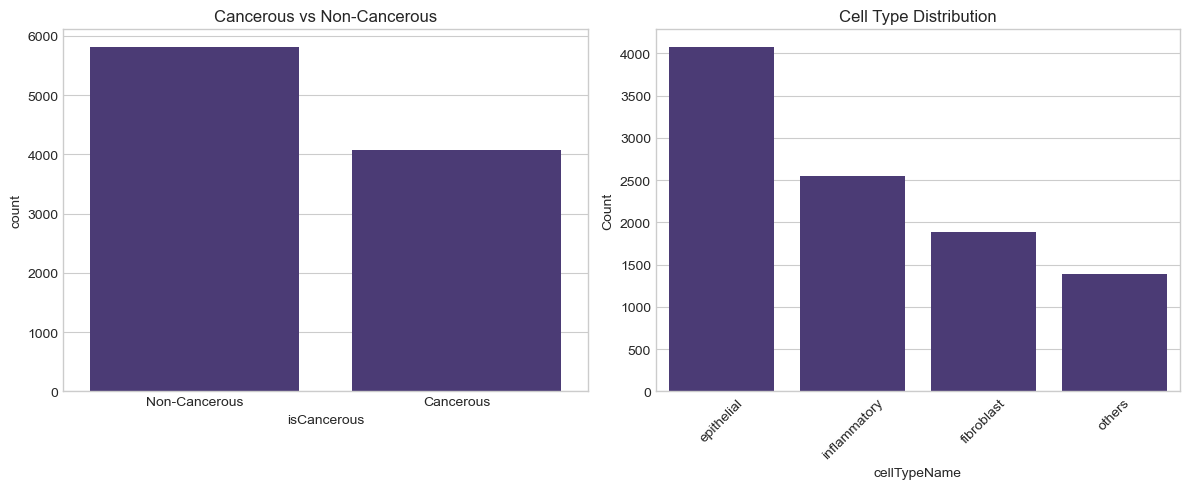

In [67]:
plot_categorical_distribution(data)

The generated graphs depict the the distribution of the two categorical variables: **isCanerous** and **cellType**. From the graph, the distribution is not distributed evenly. Therefore, when splitting the data to train and test sets, both sets should have the classes to train or test. Also, the miniroty should have enough data to train 

In [68]:
# Create a combined label per patient for stratification (if patients have varying labels)
patient_data = data.groupby('patientID').agg({
    'cellType': lambda x: x.mode()[0],  # Or a more robust method if needed
    'isCancerous': lambda x: x.mode()[0]
}).reset_index()

# Create stratification target per patient
patient_data['combined_target'] = patient_data['cellType'].astype(str) + '_' + patient_data['isCancerous'].astype(str)

# Split patient IDs
train_patients, test_patients = train_test_split(
    patient_data['patientID'],
    test_size=0.20,
    random_state=0,
    stratify=patient_data['combined_target']
)

# Filter the main data by patient ID
train_data = data[data['patientID'].isin(train_patients)]
test_data = data[data['patientID'].isin(test_patients)]

# Define targets
y_train = train_data['cellType'].astype(str) + '_' + train_data['isCancerous'].astype(str)
y_test = test_data['cellType'].astype(str) + '_' + test_data['isCancerous'].astype(str)

In [69]:
print(f"The train dataset now has: {train_data.shape[0]} rows and {train_data.shape[1]} columns")

The train dataset now has: 7768 rows and 6 columns


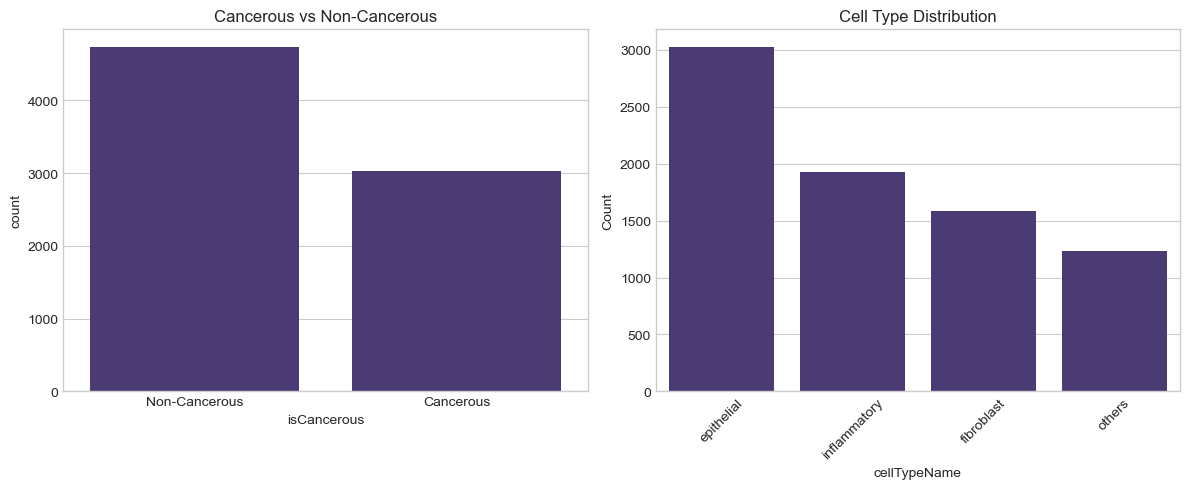

In [70]:
plot_categorical_distribution(train_data)

From the generated figures, the train set contains enough data to train as the minority classes has more than 1000 samples. Also, the distribution of the classes remains.

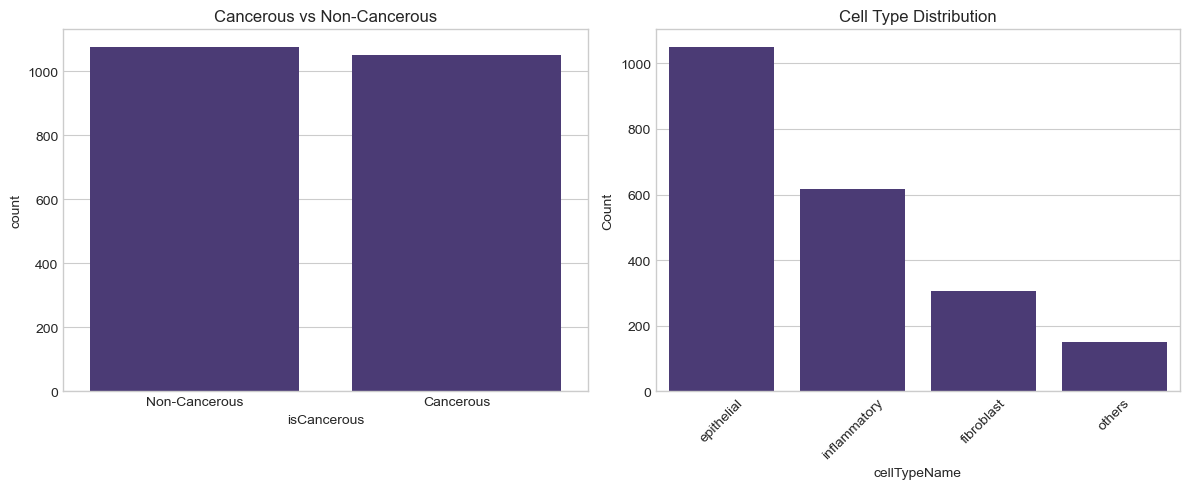

In [71]:
plot_categorical_distribution(test_data)

From the generated figures, the test set contains enough data to train as the minority classes has more than 1000 samples. Also, the distribution of the classes remains.

**Data leakage check**

In [72]:
# This code is used to do the final check to ensure that there is no instances that appear in both train and set set
patient_train_data = train_data['patientID'].unique()
patient_test_data = test_data['patientID'].unique()

res = list(set(patient_train_data) & set(patient_test_data))
if len(res) == 0:
    print("In both train and test sets, there is no record with same ID")
else:
    print("WARN: The dataset has leakage issue")

In both train and test sets, there is no record with same ID


In [73]:
train_data.head()

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous
19,19035,2,19035.png,fibroblast,0,0
20,19036,2,19036.png,fibroblast,0,0
21,19037,2,19037.png,fibroblast,0,0
22,19038,2,19038.png,fibroblast,0,0
23,19039,2,19039.png,fibroblast,0,0


In [74]:
# export to csv the parent dataset
train_data.to_csv('./data/train.csv', index=False)
test_data.to_csv('./data/test.csv', index=False)

In [75]:
# this code is created to separate the is_cancerous dataframe
is_cancerous_train = train_data.copy()
is_cancerous_train.drop(['cellTypeName', 'cellType'], axis=1, inplace=True)
is_cancerous_test = test_data.copy()
is_cancerous_test.drop(['cellTypeName', 'cellType'], axis=1, inplace=True)

is_cancerous_train.to_csv('./data/is_cancerous_train.csv', index=False)
is_cancerous_test.to_csv('./data/is_cancerous_test.csv', index=False)

In [76]:
# this code is created to separate the cell_type dataframe

cell_type_train = train_data.copy()
cell_type_train.drop(['isCancerous'], axis=1, inplace=True)
cell_type_test = test_data.copy()
cell_type_test.drop(['cellTypeName'], axis=1, inplace=True)

cell_type_train.to_csv('./data/cell_type_train.csv', index=False)
cell_type_test.to_csv('./data/cell_type_test.csv', index=False)

In [77]:
# delete variables for saving memory
del train_data, test_data, is_cancerous_train, is_cancerous_test, cell_type_train, cell_type_test, data

## 4. Exploratory data analysis

### Basic information

In [78]:
# Load the data set
dataset_path = './data/train.csv'
data = pd.read_csv(dataset_path)

In [79]:
print("Dataset Overview:")
print(f"Dataset shape: {data.shape}")
print("\nFirst few rows:")
print(data.head())

Dataset Overview:
Dataset shape: (7768, 6)

First few rows:
   InstanceID  patientID  ImageName cellTypeName  cellType  isCancerous
0       19035          2  19035.png   fibroblast         0            0
1       19036          2  19036.png   fibroblast         0            0
2       19037          2  19037.png   fibroblast         0            0
3       19038          2  19038.png   fibroblast         0            0
4       19039          2  19039.png   fibroblast         0            0


In [80]:
# 2. Basic Data Information
print("\n--- Data Information ---")
print(data.info())


--- Data Information ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7768 entries, 0 to 7767
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   InstanceID    7768 non-null   int64 
 1   patientID     7768 non-null   int64 
 2   ImageName     7768 non-null   object
 3   cellTypeName  7768 non-null   object
 4   cellType      7768 non-null   int64 
 5   isCancerous   7768 non-null   int64 
dtypes: int64(4), object(2)
memory usage: 364.2+ KB
None


In [81]:
print("\n--- Missing Values ---")
print(data.isnull().sum())


--- Missing Values ---
InstanceID      0
patientID       0
ImageName       0
cellTypeName    0
cellType        0
isCancerous     0
dtype: int64


The data_labels_mainData.csv dataset has 9896 rows and 6 columns, in which there are two ID columns including the InstanceID and patientID. The two columns **cellType** and **isCancerous** are two target variables. The cellTypeName is the text version of the **cellType** column. For the independent columns, ImageName the path to the image located under **patches_images** folder. The dataset does not have any missing value.

### Explore the categorical variables

#### isCancerous variable

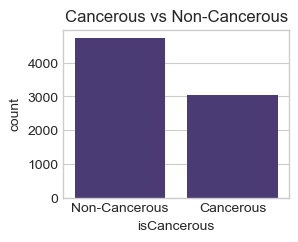

In [82]:
# 4.2 Cancerous Distribution
plt.subplot(2, 2, 2)
sns.countplot(x='isCancerous', data=data)
plt.title('Cancerous vs Non-Cancerous')
plt.xticks([0, 1], ['Non-Cancerous', 'Cancerous'])
plt.show()

In [83]:
is_cancerous_counts = data[['isCancerous']].value_counts().reset_index()
is_cancerous_counts.columns = ['isCancerous', 'Count']
is_cancerous_counts

,isCancerous,Count
0,0,4740
1,1,3028


The distribution of the isCancerous variable is imbalanced, as the number of **Cancerous** sample is less than 36.12% comparing to the **Non-Cancerous**.

#### Cell Type

In [84]:
cell_type_counts = data[['cellType', 'cellTypeName']].value_counts().reset_index()
cell_type_counts.columns = ['cellType', 'cellTypeName', 'Count']
cell_type_counts

,cellType,cellTypeName,Count
0,2,epithelial,3028
1,1,inflammatory,1925
2,0,fibroblast,1581
3,3,others,1234


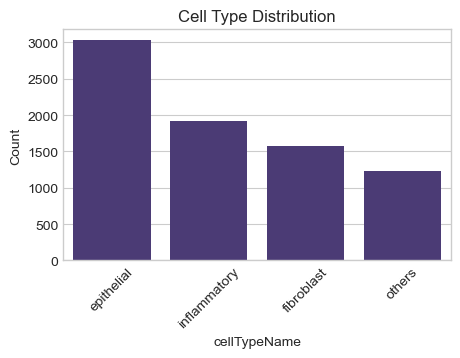

In [85]:
plt.figure(figsize=(5, 3))
sns.barplot(cell_type_counts, x="cellTypeName", y="Count")
plt.title('Cell Type Distribution')
plt.xticks(rotation=45)
plt.show()

For the cell type varible, the cell type is already encoded, which is shown in the following table. 

| Cell type name | Encoded value |
| - | - |
| fibroblast | 0 |
| inflammatory | 1 |
| epithelial | 2 |
| others | 3 |


Also, the distribution of the cell type shows that the classes are imbalanced. For example, the **epithelial** class has 4079 instances, which is nearly twice (~2.16) as many as the fibroblast class.

### Patient distribution

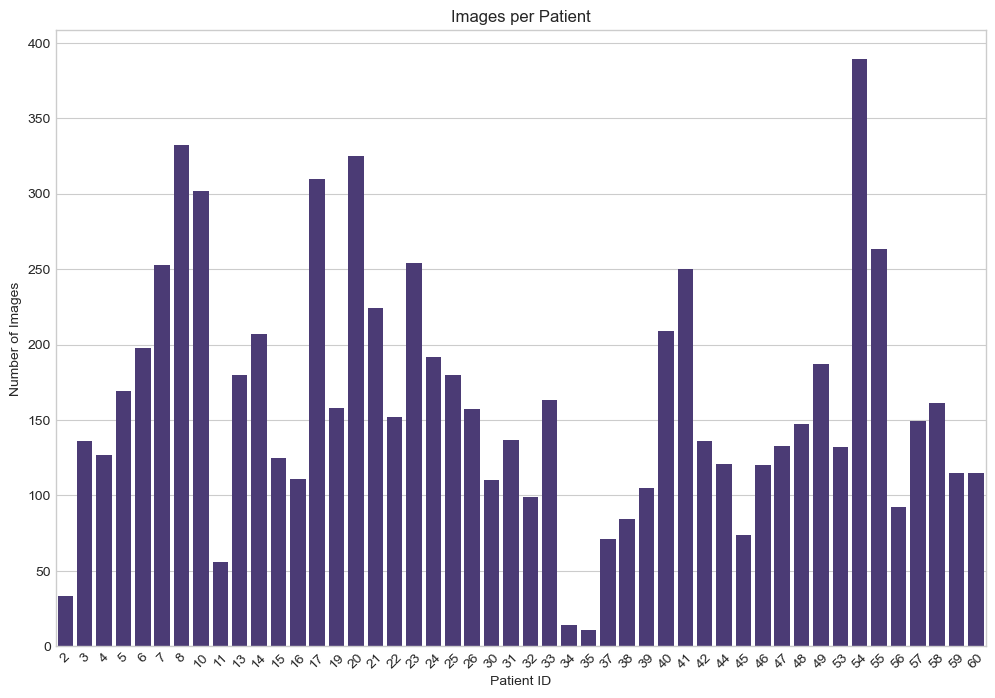

In [86]:
patient_counts = data['patientID'].value_counts()
plt.figure(figsize=(12, 8))

sns.barplot(x=patient_counts.index, y=patient_counts.values)

plt.title('Images per Patient')
plt.xlabel('Patient ID')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.show()

In [87]:
sorted_counts = patient_counts.sort_values(ascending=False)
sorted_counts.head(10)

patientID
54    389
8     332
20    325
17    310
10    302
55    263
23    254
7     253
41    250
21    224
Name: count, dtype: int64

In [88]:
sorted_counts.tail(10)

patientID
39    105
32     99
56     92
38     84
45     74
37     71
11     56
2      33
34     14
35     11
Name: count, dtype: int64

From the given chart, the provided images for each patient is not distributed evenly. For example, the patient **54** has 389 instances, wherease, there are only **11** instances for patient 35.

### Cell type and Cancerous Status

This section aims to examine the relationsip between two categorical varibales (isCanerous and cellType) to answer the question in which cell type is detected, the patient will have cancer?

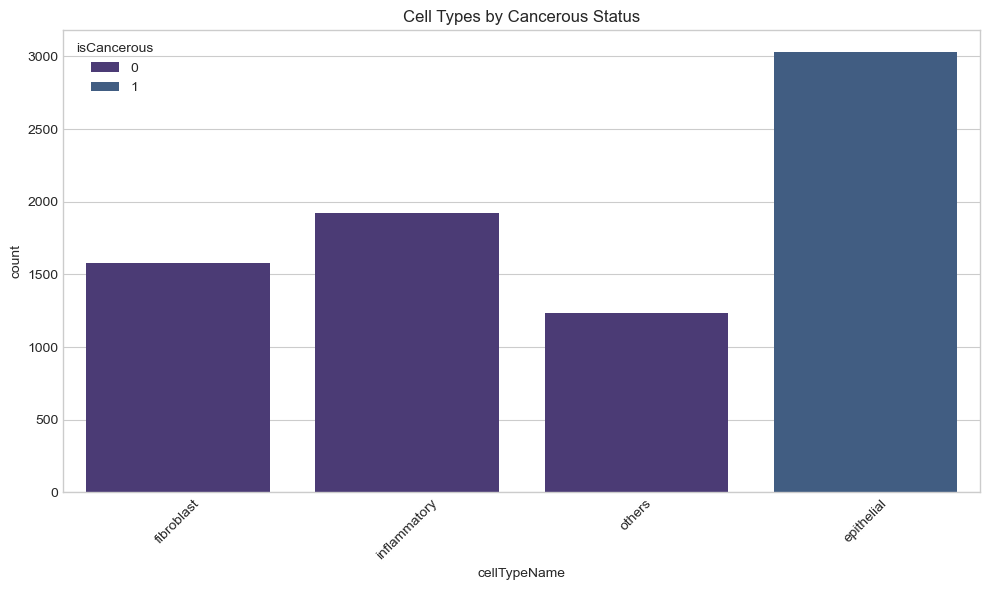

In [89]:
plt.figure(figsize=(10, 6))
sns.countplot(x='cellTypeName', hue='isCancerous', data=data)
plt.title('Cell Types by Cancerous Status')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

From the given chart, it is noticeable that when the epithelial cell type is detected, the patient is diagonised as having cancer.

### Image analysis

The image is analyzed with three main aspects, including: **aspect ratio**, **size**, **color chanel**

**Image sizes**

Text(0.5, 1.0, 'Distribution of Image Dimensions')

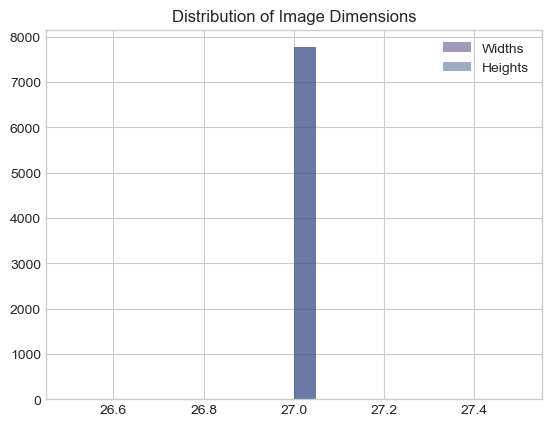

In [90]:
# TODO: add the code for the image analysis here. Check for the size, noise and resolution
from collections import Counter
sizes = [Image.open(f"./data/patch_images/{img}").size for img in data['ImageName'].values]
widths, heights = zip(*sizes)
plt.hist(widths, bins=20, alpha=0.5, label='Widths')
plt.hist(heights, bins=20, alpha=0.5, label='Heights')
plt.legend()
plt.title("Distribution of Image Dimensions")

In [91]:

# Set style for plots
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")

def analyze_images_by_cell_type(data, image_dir, cell_type_name):
    
    # Check if directory exists
    if not os.path.exists(image_dir):
        print(f"Image directory {image_dir} not found. Skipping analysis.")
        return
    
    # Create dictionaries to store sample images and their analyses
    sample_images = {}
    image_analyses = defaultdict(dict)
    
    # Get all images of this cell type
    cell_type_images = data[data['cellTypeName'] == cell_type_name]['ImageName'].tolist()
    
    if not cell_type_images:
        print(f"No images found for cell type {cell_type} ({cell_type_name})")
        return    
    # Randomly select one image
    selected_img_name = random.choice(cell_type_images)
    image_path = os.path.join(image_dir, selected_img_name)
    
    try:
        # Try to read the image
        img = cv2.imread(image_path)
        
        if img is None:
            print(f"Could not read image: {image_path}")
            return
            
        # Store the image and its details
        sample_images[cell_type_name] = {
            'name': selected_img_name,
            'image': img,
            'cell_type_name': cell_type_name
        }
        
        # Perform analysis
        image_analyses[cell_type_name] = analyze_single_image(img, selected_img_name, cell_type_name)
        
    except Exception as e:
        print(f"Error processing image {image_path}: {str(e)}")
    
    # Create visualizations
    if sample_images:
        # Create a comprehensive figure with subplots
        visualize_image_analyses(sample_images, image_analyses)
    else:
        print("No images could be processed for analysis.")

def analyze_single_image(img, img_name, cell_type_name):
    # Convert BGR to RGB for analysis
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Convert to HSV and LAB color spaces for additional analysis
    img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    img_lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    
    # Convert to grayscale
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Basic image properties
    height, width, channels = img.shape
    
    # Intensity analysis
    channel_names = ['Red', 'Green', 'Blue']
    channel_stats = {}
    
    for i, channel_name in enumerate(channel_names):
        channel = img_rgb[:,:,i]
        channel_stats[channel_name] = {
            'mean': np.mean(channel),
            'std': np.std(channel),
            'min': np.min(channel),
            'max': np.max(channel),
            'median': np.median(channel),
            'histogram': np.histogram(channel, bins=256, range=(0,256))[0]
        }
    
    # Grayscale intensity
    gray_stats = {
        'mean': np.mean(img_gray),
        'std': np.std(img_gray),
        'min': np.min(img_gray),
        'max': np.max(img_gray),
        'median': np.median(img_gray),
        'histogram': np.histogram(img_gray, bins=256, range=(0,256))[0]
    }
    
    # HSV analysis
    hsv_names = ['Hue', 'Saturation', 'Value']
    hsv_stats = {}
    
    for i, hsv_name in enumerate(hsv_names):
        channel = img_hsv[:,:,i]
        hsv_stats[hsv_name] = {
            'mean': np.mean(channel),
            'std': np.std(channel),
            'min': np.min(channel),
            'max': np.max(channel),
            'median': np.median(channel),
            'histogram': np.histogram(channel, bins=256, range=(0,256))[0]
        }
    
    # Calculate texture features using GLCM or other methods if needed
    # (Code for texture analysis would go here)
    
    # Calculate basic edge statistics
    edges = cv2.Canny(img_gray, 100, 200)
    edge_percentage = np.sum(edges > 0) / (height * width) * 100
    
    return {
        'filename': img_name,
        'cell_type': cell_type_name,
        'dimensions': {'height': height, 'width': width, 'channels': channels},
        'size_bytes': img.nbytes,
        'rgb_stats': channel_stats,
        'gray_stats': gray_stats,
        'hsv_stats': hsv_stats,
        'edge_percentage': edge_percentage
    }

def visualize_image_analyses(sample_images, image_analyses):
    n_cell_types = len(sample_images)
    
    for cell_type, img_data in sample_images.items():
        analysis = image_analyses[cell_type]
        img = img_data['image']
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        cell_type_name = img_data['cell_type_name']
        img_name = img_data['name']
        
        # Create a large figure with multiple subplots
        fig = plt.figure(figsize=(20, 16))
        gs = gridspec.GridSpec(4, 4)
        
        # Title with image and cell information
        plt.suptitle(f"Analysis of {img_name} - {cell_type_name} (Cell Type {cell_type})", 
                     fontsize=16, y=0.98)
        
        # 1. Original Image
        ax1 = plt.subplot(gs[0, 0])
        ax1.imshow(img_rgb)
        ax1.set_title("Original Image")
        ax1.axis('off')

        # 2. RGB Channels
        # Red Channel
        ax2 = plt.subplot(gs[0, 1])
        ax2.imshow(img_rgb[:,:,0], cmap='Reds')
        ax2.set_title("Red Channel")
        ax2.axis('off')
        
        # Green Channel
        ax3 = plt.subplot(gs[0, 2])
        ax3.imshow(img_rgb[:,:,1], cmap='Greens')
        ax3.set_title("Green Channel")
        ax3.axis('off')
        
        # Blue Channel
        ax4 = plt.subplot(gs[0, 3])
        ax4.imshow(img_rgb[:,:,2], cmap='Blues')
        ax4.set_title("Blue Channel")
        ax4.axis('off')
        
        # 3. Grayscale Image
        ax5 = plt.subplot(gs[1, 0])
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        ax5.imshow(img_gray, cmap='gray')
        ax5.set_title("Grayscale")
        ax5.axis('off')
        
        # 4. Edge Detection
        ax6 = plt.subplot(gs[1, 1])
        edges = cv2.Canny(img_gray, 100, 200)
        ax6.imshow(edges, cmap='gray')
        ax6.set_title(f"Edges ({analysis['edge_percentage']:.2f}% pixels)")
        ax6.axis('off')
        
        # 5. HSV Representation
        ax7 = plt.subplot(gs[1, 2])
        img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        ax7.imshow(cv2.cvtColor(img_hsv, cv2.COLOR_HSV2RGB))
        ax7.set_title("HSV Representation")
        ax7.axis('off')
        
        # 6. Histogram Equalized
        ax8 = plt.subplot(gs[1, 3])
        img_eq = exposure.equalize_hist(img_gray)
        ax8.imshow(img_eq, cmap='gray')
        ax8.set_title("Histogram Equalized")
        ax8.axis('off')
        
        plt.tight_layout(rect=[0, 0, 1, 0.97])
        plt.show()



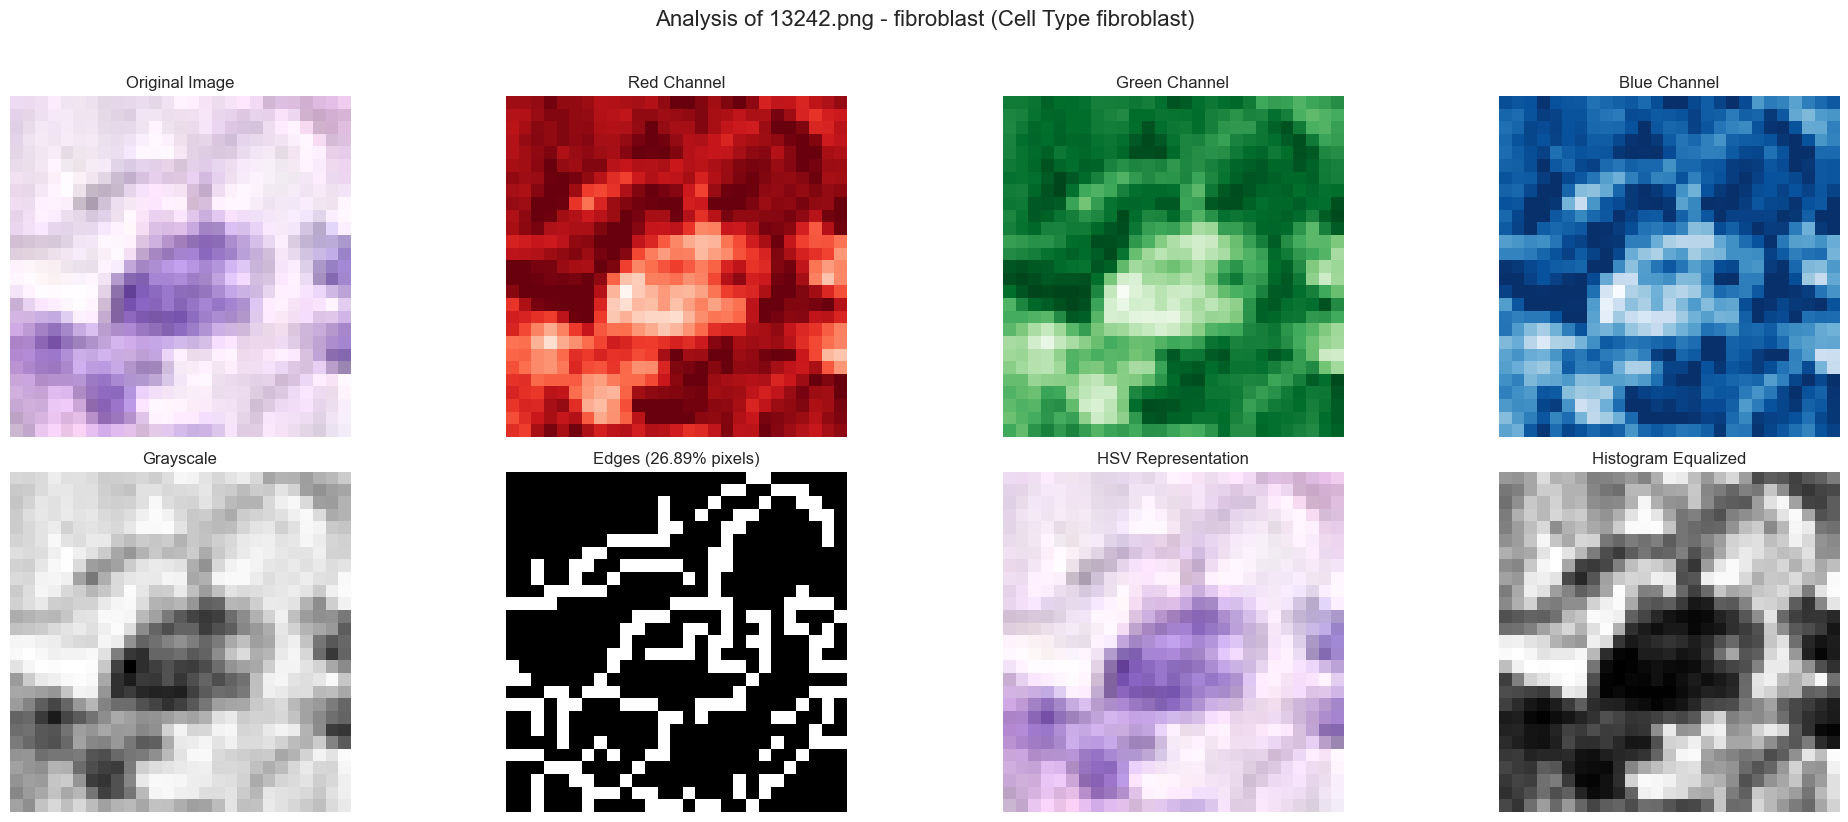

In [92]:
# Due to the constraint of the words, only one cell type is analyzed
image_dir = "./data/patch_images"
analyze_images_by_cell_type(data, image_dir, 'fibroblast')

The nucleus or cell center is clearly defined in the Blue and Grayscale images. Edge detection successfully highlights internal and external cell boundaries.

In [93]:
# This code is used to validate if the image containing the embedded text
def check_text_in_image(image_path, conf_threshold=60):
    try:
        image_path = './data/patch_images'
        image = cv2.imread(image_path)
        if image is None:
            return False  # image could not be read

        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        _, thresh = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY_INV)

        custom_config = r'--oem 3 --psm 6'
        data = pytesseract.image_to_data(thresh, config=custom_config, output_type=pytesseract.Output.DICT)

        for i in range(len(data['text'])):
            if int(data['conf'][i]) > conf_threshold and data['text'][i].strip():
                return True
        return False
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return False

# Apply function to DataFrame
data['has_text'] = data['ImageName'].apply(check_text_in_image)

In [94]:
data.shape

(7768, 7)

In [95]:
no_embedded_text = data['has_text'].value_counts().get(False, 0)
if data.shape[0] == no_embedded_text:
    print('There is no embedded text in the given dataset.')
else:
    print('There is embedded text in the given dataset.')

There is no embedded text in the given dataset.


### EDA Summary

**Dataset Overview**
- Size: 9,896 samples with 6 columns
- Structure: 2 ID columns + 3 categorical variables (cellTypeName, cellType, isCancerous)
- Prediction targets: Cell type classification and cancer detection from image patches

**Key Insights**

- Cell types encoded as numeric values
- **Class imbalance present in distribution**
- No additional features beyond images and categorical labels

## Data preprocessing

- **Image Normalization**: Rescaling pixel values from 0-255 to 0-1 range to prevent dominant terms
- **Imbalance Handling**: Oversampling with augmentation to create synthetic minority class samples. Augmentation techniques follow the methodology from the reference paper (rotate, flip, location shifting and hsv perturbation)

Both preprocessing steps will be integrated into the training pipeline.

In [96]:
def preprocess_image(image_path, image_size=(27, 27)):
    normalization_layer = Rescaling(1./255)
    image = tf.io.read_file(image_path)
    image = tf.image.decode_image(image, channels=3)
    image = tf.image.resize(image, image_size)
    image = tf.cast(image, tf.float32)
    image = normalization_layer(image)  # Apply Keras rescaling
    return image


2025-05-19 01:08:32.247789: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2025-05-19 01:08:32.247814: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 18.00 GB
2025-05-19 01:08:32.247825: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 6.00 GB
2025-05-19 01:08:32.247848: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-05-19 01:08:32.247863: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


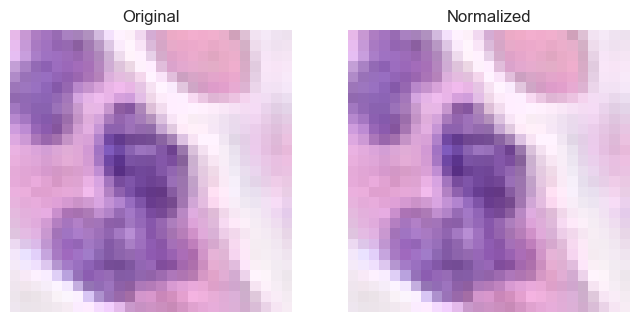

In [97]:
random_row = data.sample(1).iloc[0]
image_path = './data/patch_images/' + random_row['ImageName']

original_img = cv2.imread(image_path)
norm_img_tf = preprocess_image(image_path)

# Convert to numpy and scale back to uint8
image_np = norm_img_tf.numpy()
image_uint8 = (image_np * 255).astype(np.uint8)

# Convert RGB (TensorFlow) to BGR (OpenCV)
norm_img = cv2.cvtColor(image_uint8, cv2.COLOR_RGB2BGR)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.title("Original")
plt.imshow(cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Normalized")
plt.imshow(cv2.cvtColor(norm_img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

The following code is used to show that the data augmentation works in the pipeline. We used the same approach mentioned in the paper.

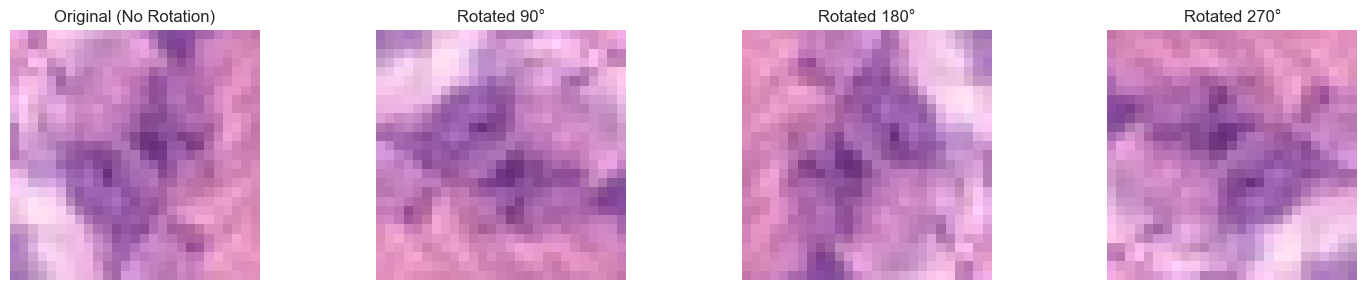

In [98]:
# Data augmentation: rotate
random_row = data.sample(1).iloc[0]
image_path = './data/patch_images/' + random_row['ImageName']
original_img = cv2.imread(image_path)
original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)  # Ensure proper color for plt

def rotate_image(img, angle):
    if angle == 90:
        return "Rotated 90°", cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
    elif angle == 180:
        return "Rotated 180°", cv2.rotate(img, cv2.ROTATE_180)
    elif angle == 270:
        return "Rotated 270°", cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)
    else:
        return "Original (No Rotation)", img.copy()

rotated_img = [rotate_image(original_img, 0)]  # Include original
for angle in [90, 180, 270]:
    rotated_img.append(rotate_image(original_img, angle))

plt.figure(figsize=(15, 3))
for i, (title, img) in enumerate(rotated_img):
    plt.subplot(1, len(rotated_img), i + 1)
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')
plt.tight_layout()
plt.show()


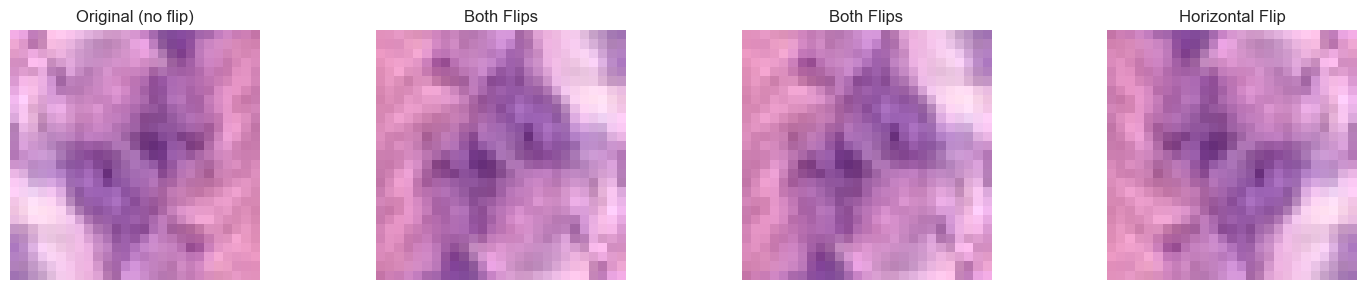

In [99]:
# Data augmentation: flip the image
def flip_image(img, flip_code):
    flip_code = random.choice([-1, 0, 1])
    flipped = cv2.flip(img, flip_code)
    direction = {1: "Horizontal Flip", 0: "Vertical Flip", -1: "Both Flips"}[flip_code]
    return direction, flipped

flipped_imgs = [('Original (no flip)', original_img)]  # Include original
for angle in [-1, 0, 1]:
    flipped_imgs.append(flip_image(original_img, angle))

plt.figure(figsize=(15, 3))
for i, (title, img) in enumerate(flipped_imgs):
    plt.subplot(1, len(flipped_imgs), i + 1)
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')
plt.tight_layout()
plt.show()


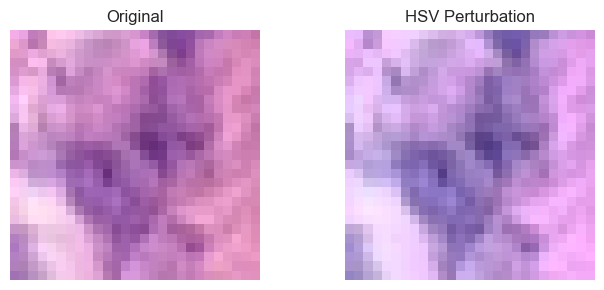

In [100]:
# Data augmentation: HSV perturbation
def hsv_perturbation(img):
    hsv_img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV).astype(np.float32)
    h_factor = random.uniform(0.8, 1.2)
    s_factor = random.uniform(0.8, 1.2)
    v_factor = random.uniform(0.8, 1.2)
    hsv_img[:, :, 0] = np.clip(hsv_img[:, :, 0] * h_factor, 0, 179)
    hsv_img[:, :, 1] = np.clip(hsv_img[:, :, 1] * s_factor, 0, 255)
    hsv_img[:, :, 2] = np.clip(hsv_img[:, :, 2] * v_factor, 0, 255)
    return "HSV Perturbation", cv2.cvtColor(hsv_img.astype(np.uint8), cv2.COLOR_HSV2RGB)

hsv_perturbation_imgs = [('Original', original_img)]  # Include original
hsv_perturbation_imgs.append(hsv_perturbation(original_img))

plt.figure(figsize=(7, 3))
for i, (title, img) in enumerate(hsv_perturbation_imgs):
    plt.subplot(1, len(hsv_perturbation_imgs), i + 1)
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')
plt.tight_layout()
plt.show()

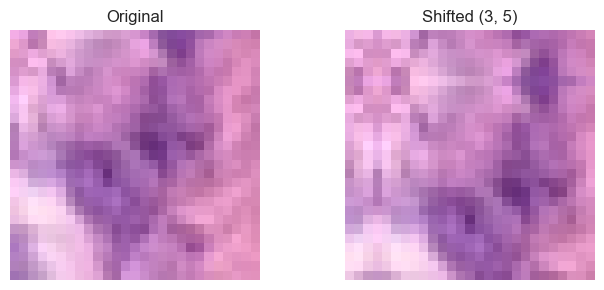

In [101]:
# Data augmentation: Location shift
def location_shift(img):
    h, w = img.shape[:2]
    max_shift_h = h // 5
    max_shift_w = w // 5
    shift_h = random.randint(-max_shift_h, max_shift_h)
    shift_w = random.randint(-max_shift_w, max_shift_w)
    M = np.float32([[1, 0, shift_w], [0, 1, shift_h]])
    shifted = cv2.warpAffine(img, M, (w, h), borderMode=cv2.BORDER_REFLECT_101)
    return f"Shifted ({shift_w}, {shift_h})", shifted

location_shifted_imgs = [('Original', original_img)]  # Include original
location_shifted_imgs.append(location_shift(original_img))

plt.figure(figsize=(7, 3))
for i, (title, img) in enumerate(location_shifted_imgs):
    plt.subplot(1, len(location_shifted_imgs), i + 1)
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')
plt.tight_layout()
plt.show()

In [102]:
# Since tensorflow is not capable with HSV perturbation, so we have created a custom class. Also, to avoid the bias in the generated 
# data, we applied some randomness check so that the generated image can have multiple forms.
class CustomDataAugmentor:
    def __init__(self):
        # Basic rescaling only for the standard generator
        self.base_generator = ImageDataGenerator(
            rescale=1. / 255,
            data_format='channels_last'
        )
    
    def augment_batch(self, X_batch, y_batch=None):
        """
        Apply custom augmentations to a batch of images as described in the paper:
        - Specific rotations (0°, 90°, 180°, 270°)
        - Vertical or horizontal flipping
        - HSV color perturbation
        - Location variations
        """
        augmented_images = []
        augmented_labels = []
        
        for i, img in enumerate(X_batch):
            # Make a copy of the original image
            augmented_img = img.copy()
            
            # 1. Rotate image (0°, 90°, 180°, 270°)
            rotation_angle = random.choice([0, 90, 180, 270])
            if rotation_angle > 0:
                if rotation_angle == 90:
                    augmented_img = cv2.rotate(augmented_img, cv2.ROTATE_90_CLOCKWISE)
                elif rotation_angle == 180:
                    augmented_img = cv2.rotate(augmented_img, cv2.ROTATE_180)
                elif rotation_angle == 270:
                    augmented_img = cv2.rotate(augmented_img, cv2.ROTATE_90_COUNTERCLOCKWISE)
            
            # 2. horizontal or vertical flipping
            if random.random() < 0.5:
                augmented_img = cv2.flip(augmented_img, 1)  # horizontal flip
            if random.random() < 0.5:
                augmented_img = cv2.flip(augmented_img, 0)  # vertical flip
            
            # 3. Apply HSV color perturbation as described in the paper
            if random.random() < 0.7:  # Apply color augmentation with 70% probability
                # Convert to HSV
                hsv_img = cv2.cvtColor(augmented_img, cv2.COLOR_RGB2HSV).astype(np.float32)
                
                # Random factors for H, S, and V as described in the paper
                h_factor = random.uniform(0.8, 1.2)  # Random factor for Hue
                s_factor = random.uniform(0.8, 1.2)  # Random factor for Saturation
                v_factor = random.uniform(0.8, 1.2)  # Random factor for Value
                
                # Apply the random factors
                hsv_img[:, :, 0] = np.clip(hsv_img[:, :, 0] * h_factor, 0, 179)
                hsv_img[:, :, 1] = np.clip(hsv_img[:, :, 1] * s_factor, 0, 255)
                hsv_img[:, :, 2] = np.clip(hsv_img[:, :, 2] * v_factor, 0, 255) 
                
                # Convert back to RGB
                augmented_img = cv2.cvtColor(hsv_img.astype(np.uint8), cv2.COLOR_HSV2RGB)
            
            # 4. Apply location shift
            if random.random() < 0.5:
                # Apply random shift within the image
                height, width = augmented_img.shape[:2]
                max_shift_h = height // 5  # Allow shifting up to 20% of height
                max_shift_w = width // 5   # Allow shifting up to 20% of width
                
                shift_h = random.randint(-max_shift_h, max_shift_h)
                shift_w = random.randint(-max_shift_w, max_shift_w)
                
                # Create transformation matrix for shifting
                M = np.float32([[1, 0, shift_w], [0, 1, shift_h]])
                augmented_img = cv2.warpAffine(augmented_img, M, (width, height), borderMode=cv2.BORDER_REFLECT_101)
            
            augmented_img = augmented_img / 255.0
            
            augmented_images.append(augmented_img)
            if y_batch is not None:
                augmented_labels.append(y_batch[i])
        
        return np.array(augmented_images), np.array(augmented_labels) if y_batch is not None else None

    # Some default methods when create custom data generator class from tensorflow
    def flow_from_directory(self, directory, **kwargs):
        """
        Create a generator that yields augmented batches from a directory
        """
        base_gen = self.base_generator.flow_from_directory(directory, **kwargs)
        
        while True:
            X_batch = next(base_gen)
            aug_X_batch = self.augment_batch(X_batch, y_batch)
            yield aug_X_batch, aug_y_batch
    
    def flow(self, X, y=None, **kwargs):
        """
        Create a generator that yields augmented batches from memory
        """
        base_gen = self.base_generator.flow(X, y, **kwargs)
        
        while True:
            # Handle the case where y is None (no labels)
            batch = next(base_gen)
            if y is None:
                X_batch = batch
                y_batch = None
            else:
                X_batch, y_batch = batch
                
            aug_X_batch, aug_y_batch = self.augment_batch(X_batch, y_batch)
            
            if y is None:
                yield aug_X_batch
            else:
                yield aug_X_batch, aug_y_batch

## Model development strategy
Our approach for both classification tasks (**isCancerous** and **cellType**) follows this development process:

1. Train baseline models using traditional machine learning algorithms (Logistic Regression, Random Forest, and SVM) with feature extraction
  - Advantages: interpretability of results, faster development cycle, lower computational requirements, good performance with limited training data
  - Provides critical insights into feature importance and relationships in the cancer data

2. Fine-tune these models to select the best traditional approach
  - Optimize hyperparameters through grid search and cross-validation
  - Identify the most relevant features and evaluate their predictive power

3. Enhance performance using deep learning approaches (MLP and CNN)
  - Advantages: ability to automatically learn complex patterns, potentially higher accuracy, reduced need for manual feature engineering
  - MLPs for processing extracted features, CNNs for direct image analysis
  - Capacity to identify subtle visual patterns possibly missed by traditional methods

4. Conduct thorough hyperparameter tuning for neural networks
  - Optimize architecture, learning rates, regularization techniques
  - Implement techniques to prevent overfitting (dropout, early stopping)
  - Test various activation functions and optimization algorithms

5. Perform comprehensive performance comparison between traditional ML and deep learning
  - Evaluate across multiple metrics (weighted F1 Score, AUC-ROC, Recall, and Precision)
  - Assess trade-offs between model complexity, interpretability, and performance
  - Determine the most appropriate approach based on clinical requirements and constraints

This progressive methodology leverages the complementary strengths of both traditional and deep learning approaches to develop optimal cancer classification models. 

### Model development for isCancerous classification

The objective of this task is to classify cells as cancerous or non-cancerous based on cellular images. The task can be abstract as binary classification using image. For both task we aim to use the following metrics:
- Weighted F1 Score: Balances precision and recall, particularly important since the class distributions are imbalanced
- AUC-ROC: Provides an aggregate measure of model performance across various threshold settings
- Recall: Measures the ability to correctly identify cancerous cells, critical for minimizing missed cancer diagnoses
- Precision: Quantifies the proportion of correctly identified cancerous cells among all cells classified as cancerous, helping minimize unnecessary treatments and patient anxiety from false positives


#### Development for traditional machine learning

In [103]:
# This class is created to handle K-Fold creation that ensure:
# - No duplicate patient ID between the folds
# - Ensure the class representation in each fold, since the dataset has an imbalanced issue. So it is important to ensure
# - that there is enough data to train and test
class PatientClassKFold:
    def __init__(self, n_splits=5, random_state=None, max_retries=100):
        self.n_splits = n_splits
        self.random_state = random_state
        self.max_retries = max_retries

    def split(self, X, patient_col='patientID', class_col='cellType'):
        # Group patients and classes
        patient_classes = X.groupby(patient_col)[class_col].apply(set).reset_index()
        
        patients = patient_classes[patient_col].tolist()
        patient_to_classes = dict(zip(patient_classes[patient_col], patient_classes[class_col]))
        
        rng = np.random.default_rng(self.random_state)
        
        for attempt in range(self.max_retries):
            # Shuffle patients
            shuffled_patients = patients.copy()
            rng.shuffle(shuffled_patients)
            
            # Assign patients evenly to folds
            folds = [set() for _ in range(self.n_splits)]
            for i, p in enumerate(shuffled_patients):
                folds[i % self.n_splits].add(p)
            
            # Check if each fold has all classes
            all_classes = set()
            for cls_set in patient_to_classes.values():
                all_classes.update(cls_set)
            
            valid = True
            for f in folds:
                fold_classes = set()
                for p in f:
                    fold_classes.update(patient_to_classes[p])
                if not all_classes.issubset(fold_classes):
                    valid = False
                    break
            
            if valid:
                # Generate indices
                patient_to_indices = defaultdict(list)
                for idx, patient in enumerate(X[patient_col]):
                    patient_to_indices[patient].append(idx)
                
                for i in range(self.n_splits):
                    val_patients = folds[i]
                    train_patients = set(patients) - val_patients
                    
                    val_indices = []
                    for p in val_patients:
                        val_indices.extend(patient_to_indices[p])
                    train_indices = []
                    for p in train_patients:
                        train_indices.extend(patient_to_indices[p])
                    
                    yield np.array(train_indices), np.array(val_indices)
                return
        
        raise ValueError(f"Could not create a split with all classes in each fold after {self.max_retries} attempts.")


In [104]:
# Load the train and test dataset
is_cancerous_train = pd.read_csv('./data/is_cancerous_train.csv')
is_cancerous_test = pd.read_csv('./data/is_cancerous_test.csv')

In [105]:
# This code is used to validate if the K-fold introduce any data leakage and maintain the enough sample to train and test
# of each class
kf = PatientClassKFold(n_splits=5, random_state=42)

all_classes = set(is_cancerous_train['isCancerous'].unique())

for fold, (train_idx, val_idx) in enumerate(kf.split(is_cancerous_train, patient_col='patientID', class_col='isCancerous')):
    train_fold = is_cancerous_train.iloc[train_idx].reset_index(drop=True)
    val_fold = is_cancerous_train.iloc[val_idx].reset_index(drop=True)

    train_patients = set(train_fold['patientID'].unique())
    val_patients = set(val_fold['patientID'].unique())

    # Check for patient leakage
    patient_intersection = train_patients.intersection(val_patients)
    if patient_intersection:
        print(f"WARNING: Data leakage detected in fold {fold + 1}! Patients in both train and val: {patient_intersection}")
    else:
        print(f"Fold {fold + 1}: No patient leakage detected.")

    # Check class coverage
    train_classes = set(train_fold['isCancerous'].unique())
    val_classes = set(val_fold['isCancerous'].unique())

    missing_in_train = all_classes - train_classes
    missing_in_val = all_classes - val_classes

    print(f"Fold {fold + 1} train classes count: {len(train_classes)} (missing: {missing_in_train if missing_in_train else 'None'})")
    print(f"Fold {fold + 1} val classes count: {len(val_classes)} (missing: {missing_in_val if missing_in_val else 'None'})")

    print(f"Number of unique patients in train: {len(train_patients)}")
    print(f"Number of unique patients in val: {len(val_patients)}")
    print("-" * 40)


Fold 1: No patient leakage detected.
Fold 1 train classes count: 2 (missing: None)
Fold 1 val classes count: 2 (missing: None)
Number of unique patients in train: 38
Number of unique patients in val: 10
----------------------------------------
Fold 2: No patient leakage detected.
Fold 2 train classes count: 2 (missing: None)
Fold 2 val classes count: 2 (missing: None)
Number of unique patients in train: 38
Number of unique patients in val: 10
----------------------------------------
Fold 3: No patient leakage detected.
Fold 3 train classes count: 2 (missing: None)
Fold 3 val classes count: 2 (missing: None)
Number of unique patients in train: 38
Number of unique patients in val: 10
----------------------------------------
Fold 4: No patient leakage detected.
Fold 4 train classes count: 2 (missing: None)
Fold 4 val classes count: 2 (missing: None)
Number of unique patients in train: 39
Number of unique patients in val: 9
----------------------------------------
Fold 5: No patient leakag

In [106]:
# This function is used to extract the features, when training the data
class IsCancerousImageFeatureExtractor:
    def process_and_extract_features(self, image_path, title=""):
        features = []
        # image_path = row['ImagePath']

        # Load image (assuming grayscale medical images)
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            
        # 1. Basic statistical features
        mean_intensity = np.mean(img)
        std_intensity = np.std(img)
        min_intensity = np.min(img)
        max_intensity = np.max(img)
        
        # 2. Histogram features
        hist = cv2.calcHist([img], [0], None, [32], [0, 256])
        hist_features = hist.flatten() / np.sum(hist)  # Normalize
        
        # 3. Texture features using edge detection as proxy
        edges = cv2.Canny(img, 100, 200)
        edge_density = np.sum(edges > 0) / (img.shape[0] * img.shape[1])
        
        # 4. Shape features
        # Apply thresholding
        _, thresh = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        # Calculate area and perimeter if contours exist
        if contours:
            largest_contour = max(contours, key=cv2.contourArea)
            area = cv2.contourArea(largest_contour)
            perimeter = cv2.arcLength(largest_contour, True)
            circularity = 4 * np.pi * area / (perimeter * perimeter) if perimeter > 0 else 0
        else:
            area = 0
            perimeter = 0
            circularity = 0
        
        # Combine all features
        image_features = [
            mean_intensity, std_intensity, min_intensity, max_intensity,
            edge_density, area, perimeter, circularity
        ]
        
        # Add histogram features
        image_features.extend(hist_features)
        
        features.append(image_features)
        
        return image_features


In [107]:
# This class is created as the wrapper for scikit learn model. It will:
# 1. Perform the data augmentation
# 2. Extract the features
# 3. Fit the classifier

class AugmentedFeatureModel(BaseEstimator, ClassifierMixin):
    
    def __init__(self, image_dir, classifier_name, classifier=None, random_state=42):
        self.image_dir = image_dir
        self.classifier = classifier if classifier is not None else LogisticRegression(max_iter=1000)
        self.random_state = random_state
        self.augment_times = 1
       
        self.classifier_name = classifier_name
        self.clean_up = True

    def _augment_and_resample(self, X, y):
        self.augmentor = CustomDataAugmentor()

        import uuid
        df = X.copy()
        df['label'] = y
    
        counts = df['label'].value_counts()
        max_count = counts.max()
        balanced_rows = []
    
        for label in counts.index:
            samples = df[df['label'] == label]
            n_samples = samples.shape[0]
            required = max_count - n_samples
            sampled = samples.sample(n=required, replace=True, random_state=self.random_state)
    
            for _, row in sampled.iterrows():
                image_path = os.path.join(self.image_dir, row['ImageName'])
                original = load_img(image_path)
                x = img_to_array(original)
                x = x.reshape((1,) + x.shape)
                aug_iter = self.augmentor.flow(x, batch_size=1, shuffle=False)
                aug_image = next(aug_iter)[0] * 255.0
    
                # Save augmented image temporarily
                aug_fname = f"aug_{uuid.uuid4().hex[:8]}.png"
                aug_fpath = os.path.join(self.image_aug_dir, aug_fname)
                from PIL import Image
                Image.fromarray(aug_image.astype(np.uint8)).save(aug_fpath)
    
                balanced_rows.append({'ImageName': aug_fpath, 'label': label})
    
             # Copy original images into the same folder and track
            for _, row in samples.iterrows():
                src_path = os.path.join(self.image_dir, row['ImageName'])
                dst_path = os.path.join(self.image_aug_dir, row['ImageName'])
                if not os.path.exists(dst_path):
                    shutil.copy(src_path, dst_path)
                balanced_rows.append({'ImageName': dst_path, 'label': label})
    
        df_balanced = pd.DataFrame(balanced_rows)
        return df_balanced[['ImageName']], df_balanced['label']


    def _extract_features(self, X_df, use_name_only=False):
        self.feature_extractor = IsCancerousImageFeatureExtractor()
        features = []
        for fname in X_df['ImageName']:
            if use_name_only is True:
                fname = os.path.join(self.image_dir, fname)
            feat = self.feature_extractor.process_and_extract_features(fname)
            features.append(feat)
        return np.array(features)

    def fit(self, X, y):
        # Augment + extract features
        self.instance_id = uuid.uuid4().hex[:6]
        self.image_aug_dir = f'./data/aug/{self.classifier_name}_{self.instance_id}'
        os.makedirs(self.image_aug_dir, exist_ok=True)
        
        X = X.copy()
        X_balanced, y_balanced = self._augment_and_resample(X, y)
        self.le_ = LabelEncoder().fit(y_balanced)
        y_encoded = self.le_.transform(y_balanced)
        X_features = self._extract_features(X_balanced, False)
        self.classes_ = self.le_.classes_
        self.classifier.fit(X_features, y_encoded)
        # Since the generated images is stored to disk, it consume huge amount of memory
        # so in this assignment, I will clean this up. However, in practice, this should
        # be kept to investigate and evaluate in later stage.
        if self.clean_up:
            print(f" Deleting augmented image directory: {self.image_aug_dir}")
            shutil.rmtree(self.image_aug_dir, ignore_errors=True)
        return self

    def predict(self, X):
        X_features = self._extract_features(X, True)
        y_pred = self.classifier.predict(X_features)
        return self.le_.inverse_transform(y_pred)

    def predict_proba(self, X):
        X_features = self._extract_features(X, True)
        return self.classifier.predict_proba(X_features)

    def score(self, X, y):
        y_pred = self.predict(X)
        print(len(y_pred))
        print(len(y))
        return np.mean(y_pred == y)


In [108]:
# The code is used to perform the model with default value. Based on this we can improve via tuning
def perform_cv_on_baseline_model(wrapped_model, X, y, class_name):    
    weighted_f1_scores = []
    X = is_cancerous_train[['ImageName']]
    y = is_cancerous_train['isCancerous']
    
    for fold, (train_idx, val_idx) in enumerate(kf.split(is_cancerous_train, patient_col='patientID', class_col='isCancerous')):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
        # Fit the model
        model = wrapped_model
        model.fit(X_train, y_train)
        # Predict and calculate weighted F1
        y_pred = model.predict(X_val)
        f1 = f1_score(y_val, y_pred, average='weighted')
        weighted_f1_scores.append(f1)
    
        print(f"Fold {fold + 1}: Weighted F1 = {f1:.4f}")
    
    # Final average score
    mean_f1 = np.mean(weighted_f1_scores)
    
    print(f"\nAverage Weighted F1 Score: {mean_f1:.4f}")
    print(f"Mean CV score: {np.mean(weighted_f1_scores):.4f}")
    print(f"Standard deviation: {np.std(weighted_f1_scores):.4f}")


In [169]:
# This method is used to peform Grid Search. Grid Search is only used for traditional ML as training neural network
# consume time. 
def evaluate_model_with_cv(model, model_name, param_grid, image_dir, df_train, folds, label_column='cellTypeName'):
    X_train = df_train[['ImageName']]
    y_train = df_train[[label_column]]
    groups = df_train['patientID']
    # Wrap the model in AugmentedFeatureModel
    wrapped_model = AugmentedFeatureModel(
        image_dir=image_dir,
        classifier_name=model_name,
        classifier=model
    )

    grid = GridSearchCV(
        estimator=wrapped_model,
        param_grid=param_grid,
        cv=folds,
        scoring='f1_weighted',
        verbose=1,
        n_jobs=-1
    )

    print("Starting Grid Search...")
    grid.fit(X_train, y_train)
    print("Best score:", grid.best_score_)
    print(grid.cv_results_['params'])
    print("Best params:", grid.best_params_)
    return grid.best_params_

In [170]:
# Global list to hold results
model_eval_results = []

def evaluate_binary_classifier(model, X_test, y_test, class_names=None, model_name="Model"):
    """
    Evaluate a binary classifier with labels 0 and 1.
    Stores precision, recall, AUC in global model_eval_results and returns metrics DataFrame.
    """
    y_pred = model.predict(X_test)
    y_score = model.predict_proba(X_test)
    
    # Handle class names
    if class_names is None:
        class_names = ["Class 0", "Class 1"]
    y_pred = np.array(y_pred).astype(int)
    y_test = np.array(y_test).astype(int)
    # Confusion Matrix
    cm = confusion_matrix(list(y_test), y_pred)
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=class_names))
    
    print("Confusion Matrix:")
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()
    
    # ROC Curve and AUC for binary classification
    # For binary classification, we always use the probability of class 1
    plt.figure(figsize=(7, 6))
    fpr, tpr, _ = roc_curve(y_test, y_score[:, 1])
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()
    
    # Calculate metrics
    precision = precision_score(y_test, y_pred, average=None)
    recall = recall_score(y_test, y_pred, average=None)
    
    # Prepare results
    results = {
        "model": model_name,
        "f1_weighted": f1_score(y_test, y_pred, average='weighted'),
        "precision_weighted": precision_score(y_test, y_pred, average='weighted'),
        "recall_weighted": recall_score(y_test, y_pred, average='weighted'),
        "auc": roc_auc
    }
    
    # Add per-class metrics
    for i, class_name in enumerate(class_names):
        results[f"precision_{class_name}"] = precision[i]
        results[f"recall_{class_name}"] = recall[i]
    
    # Append to global results list
    model_eval_results.append(results)
    
    # Return the updated results dataframe
    return pd.DataFrame(model_eval_results)

In [111]:
x_is_cancerous_test = is_cancerous_test[['ImageName']]
y_is_cancerous_test = is_cancerous_test['isCancerous']

model_eval_results = []

#### Logistic Regression

In [112]:
lr_init__model = AugmentedFeatureModel(
    image_dir='./data/patch_images',
    classifier_name='bin_lr_init',
    classifier=LogisticRegression(max_iter=100000)
)
perform_cv_on_baseline_model(lr_init__model, is_cancerous_train[['ImageName']], is_cancerous_train['isCancerous'], 'isCancerous')

 Deleting augmented image directory: ./data/aug/bin_lr_init_653116
Fold 1: Weighted F1 = 0.6551
 Deleting augmented image directory: ./data/aug/bin_lr_init_f81a8c
Fold 2: Weighted F1 = 0.7939
 Deleting augmented image directory: ./data/aug/bin_lr_init_a50bbe
Fold 3: Weighted F1 = 0.7238
 Deleting augmented image directory: ./data/aug/bin_lr_init_fec9d3
Fold 4: Weighted F1 = 0.7106
 Deleting augmented image directory: ./data/aug/bin_lr_init_30c1eb
Fold 5: Weighted F1 = 0.6822

Average Weighted F1 Score: 0.7131
Mean CV score: 0.7131
Standard deviation: 0.0468


In [113]:
# For this assignment, C is chosen to tune to control the overfitting vs underfitting
folds = list(kf.split(is_cancerous_train, patient_col='patientID', class_col='isCancerous'))
lr_bin_gs_params = evaluate_model_with_cv(
    model=LogisticRegression(max_iter=100000),
    model_name="aug_bin_logistic_clf",
    param_grid = {
        'classifier__C': [0.01, 0.1, 1, 10]
    },
    image_dir='./data/patch_images',
    df_train=is_cancerous_train,
    folds=folds,
    label_column='isCancerous'
)

🔍 Starting Grid Search...
Fitting 5 folds for each of 4 candidates, totalling 20 fits
 Deleting augmented image directory: ./data/aug/aug_bin_logistic_clf_b00083
✅ Best score: 0.7187629966076918
[{'classifier__C': 0.01}, {'classifier__C': 0.1}, {'classifier__C': 1}, {'classifier__C': 10}]
✅ Best params: {'classifier__C': 10}


 Deleting augmented image directory: ./data/aug/tuned_binary_lr_357a2d

Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.82      0.74      1077
           1       0.76      0.58      0.66      1051

    accuracy                           0.70      2128
   macro avg       0.71      0.70      0.70      2128
weighted avg       0.71      0.70      0.70      2128

Confusion Matrix:


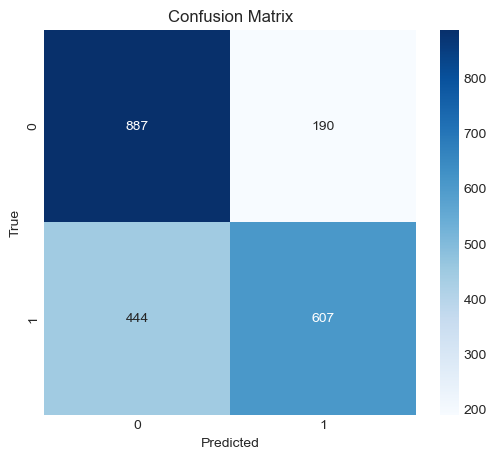

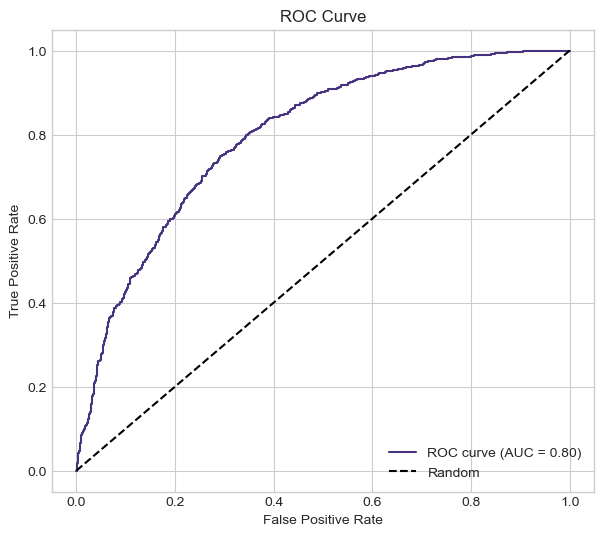

In [114]:
tuned_lr_model = AugmentedFeatureModel(
    image_dir='./data/patch_images',
    classifier_name='tuned_binary_lr',
    classifier=LogisticRegression(max_iter=100000, C=lr_bin_gs_params['classifier__C'])
)
tuned_lr_model.fit(is_cancerous_train[['ImageName']], is_cancerous_train[['isCancerous']])
lr_test_result = evaluate_binary_classifier(
    tuned_lr_model,
    x_is_cancerous_test,
    y_is_cancerous_test,
    class_names=["0", "1"],
    model_name='Binary Logistic Regression'
)

In [115]:
lr_test_result

,model,f1_weighted,precision_weighted,recall_weighted,auc,precision_0,recall_0,precision_1,recall_1
0,Binary Logistic Regression,0.697306,0.71343,0.702068,0.797983,0.666416,0.823584,0.761606,0.577545


Comparing with the pre-tuned version, the tuned version of LR slightly increase.

#### Random forest

In [116]:
rf_init__model = AugmentedFeatureModel(
    image_dir='./data/patch_images',
    classifier_name='bin_rf_init',
    classifier= RandomForestClassifier(random_state=42)
)
perform_cv_on_baseline_model(rf_init__model, is_cancerous_train[['ImageName']], is_cancerous_train['isCancerous'], 'isCancerous')

 Deleting augmented image directory: ./data/aug/bin_rf_init_5ee268
Fold 1: Weighted F1 = 0.6800
 Deleting augmented image directory: ./data/aug/bin_rf_init_bfc510
Fold 2: Weighted F1 = 0.8042
 Deleting augmented image directory: ./data/aug/bin_rf_init_906447
Fold 3: Weighted F1 = 0.7476
 Deleting augmented image directory: ./data/aug/bin_rf_init_f7a148
Fold 4: Weighted F1 = 0.7070
 Deleting augmented image directory: ./data/aug/bin_rf_init_fbab28
Fold 5: Weighted F1 = 0.7193

Average Weighted F1 Score: 0.7316
Mean CV score: 0.7316
Standard deviation: 0.0423


In [117]:
# For this assignment, max_depth and min_samples_split are chosen to tuned the tree to avoid overfitting issue and the complexity.
folds = list(kf.split(is_cancerous_train, patient_col='patientID', class_col='isCancerous'))

rf_bin_gs_params = evaluate_model_with_cv(
    model= RandomForestClassifier(random_state=42),
    model_name="aug_bin_rf_clf",
    param_grid = {
        'classifier__max_depth': [10, 20],
        'classifier__min_samples_split': [2, 5, 10],
    },
    image_dir='./data/patch_images',
    df_train=is_cancerous_train,
    folds=folds,
    label_column='isCancerous'
)

🔍 Starting Grid Search...
Fitting 5 folds for each of 6 candidates, totalling 30 fits
 Deleting augmented image directory: ./data/aug/aug_bin_rf_clf_5bc4d7
✅ Best score: 0.7354868514293542
[{'classifier__max_depth': 10, 'classifier__min_samples_split': 2}, {'classifier__max_depth': 10, 'classifier__min_samples_split': 5}, {'classifier__max_depth': 10, 'classifier__min_samples_split': 10}, {'classifier__max_depth': 20, 'classifier__min_samples_split': 2}, {'classifier__max_depth': 20, 'classifier__min_samples_split': 5}, {'classifier__max_depth': 20, 'classifier__min_samples_split': 10}]
✅ Best params: {'classifier__max_depth': 20, 'classifier__min_samples_split': 10}


 Deleting augmented image directory: ./data/aug/tuned_binary_lr_28cc20

Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.82      0.74      1077
           1       0.76      0.58      0.66      1051

    accuracy                           0.70      2128
   macro avg       0.71      0.70      0.70      2128
weighted avg       0.71      0.70      0.70      2128

Confusion Matrix:


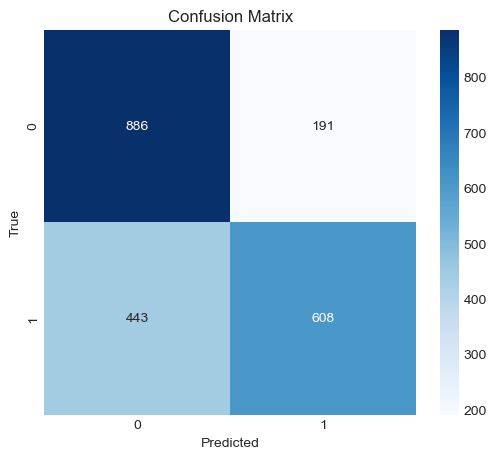

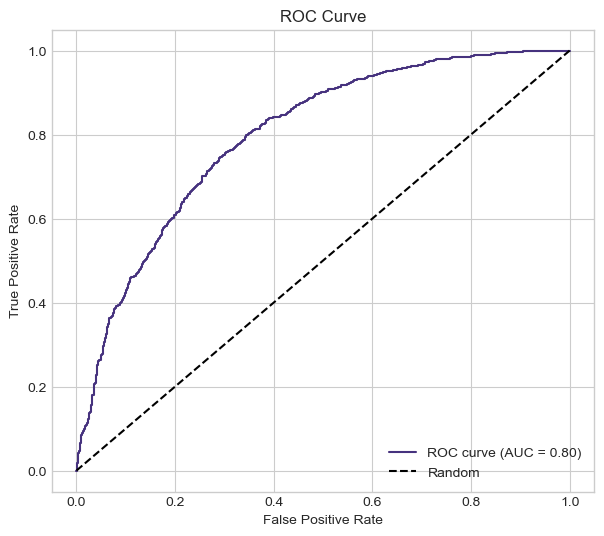

,model,f1_weighted,precision_weighted,recall_weighted,auc,precision_0,recall_0,precision_1,recall_1
0,Binary Logistic Regression,0.697306,0.713430,0.702068,0.797983,0.666416,0.823584,0.761606,0.577545
1,Random Forest,0.697379,0.713233,0.702068,0.797860,0.666667,0.822656,0.760951,0.578497


In [118]:
tuned_rf_model = AugmentedFeatureModel(
    image_dir='./data/patch_images',
    classifier_name='tuned_binary_lr',
    classifier=RandomForestClassifier(
        random_state=42,
        max_depth=rf_bin_gs_params['classifier__max_depth'],
        min_samples_split=rf_bin_gs_params['classifier__min_samples_split'],
    )
)
tuned_lr_model.fit(is_cancerous_train[['ImageName']], is_cancerous_train[['isCancerous']])
evaluate_binary_classifier(
    tuned_lr_model, 
    x_is_cancerous_test,
    y_is_cancerous_test, 
    class_names=["0", "1"],
    model_name='Random Forest'
)

#### Support Vector Machine

In [119]:
svm_init__model = AugmentedFeatureModel(
    image_dir='./data/patch_images',
    classifier_name='bin_svm_init',
    classifier= SVC(random_state=42)
)
perform_cv_on_baseline_model(svm_init__model, is_cancerous_train[['ImageName']], is_cancerous_train['isCancerous'], 'isCancerous')

 Deleting augmented image directory: ./data/aug/bin_svm_init_ff1bc3
Fold 1: Weighted F1 = 0.5627
 Deleting augmented image directory: ./data/aug/bin_svm_init_ab7d6c
Fold 2: Weighted F1 = 0.7111
 Deleting augmented image directory: ./data/aug/bin_svm_init_5a0c1b
Fold 3: Weighted F1 = 0.7273
 Deleting augmented image directory: ./data/aug/bin_svm_init_f6f774
Fold 4: Weighted F1 = 0.5957
 Deleting augmented image directory: ./data/aug/bin_svm_init_aeb2d7
Fold 5: Weighted F1 = 0.7155

Average Weighted F1 Score: 0.6624
Mean CV score: 0.6624
Standard deviation: 0.0690


In [120]:
# In this assignment, kernel in SVM to control how data is mapped into higher dimensions. 
# The right kernel improves accuracy, decision boundary shape, and overall model generalization.
folds = list(kf.split(is_cancerous_train, patient_col='patientID', class_col='isCancerous'))

svm_bin_gs_params = evaluate_model_with_cv(
    model=  SVC(random_state=42),
    model_name="aug_bin_rf_clf",
    param_grid = {
        'classifier__kernel': ['linear', 'rbf', 'poly'],
    },
    image_dir='./data/patch_images',
    df_train=is_cancerous_train,
    folds=folds,
    label_column='isCancerous'
)

🔍 Starting Grid Search...
Fitting 5 folds for each of 3 candidates, totalling 15 fits
 Deleting augmented image directory: ./data/aug/aug_bin_rf_clf_000af0
✅ Best score: 0.7161463932977274
[{'classifier__kernel': 'linear'}, {'classifier__kernel': 'rbf'}, {'classifier__kernel': 'poly'}]
✅ Best params: {'classifier__kernel': 'linear'}


 Deleting augmented image directory: ./data/aug/aug_bin_logistic_clf_47c2cd
 Deleting augmented image directory: ./data/aug/aug_bin_logistic_clf_3fb899
 Deleting augmented image directory: ./data/aug/aug_bin_rf_clf_2cc8c7
 Deleting augmented image directory: ./data/aug/aug_bin_rf_clf_6028d6
 Deleting augmented image directory: ./data/aug/aug_bin_rf_clf_cb6d45
 Deleting augmented image directory: ./data/aug/aug_bin_rf_clf_1b4a70
 Deleting augmented image directory: ./data/aug/aug_bin_logistic_clf_627cd2
 Deleting augmented image directory: ./data/aug/aug_bin_rf_clf_73c082
 Deleting augmented image directory: ./data/aug/aug_bin_rf_clf_5eb849
 Deleting augmented image directory: ./data/aug/aug_bin_rf_clf_8e9612
 Deleting augmented image directory: ./data/aug/aug_bin_rf_clf_69255d
 Deleting augmented image directory: ./data/aug/aug_bin_logistic_clf_5adb29
 Deleting augmented image directory: ./data/aug/aug_bin_logistic_clf_de5590
 Deleting augmented image directory: ./data/aug/aug_bin_rf_c

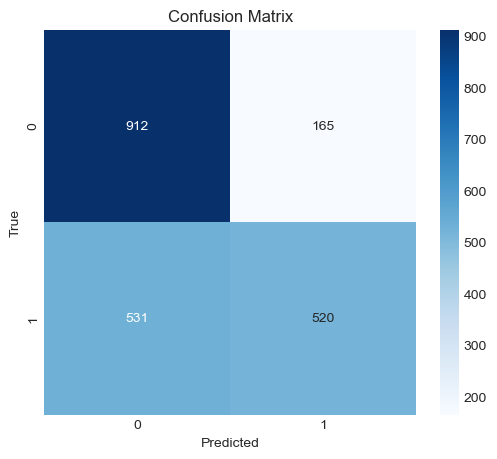

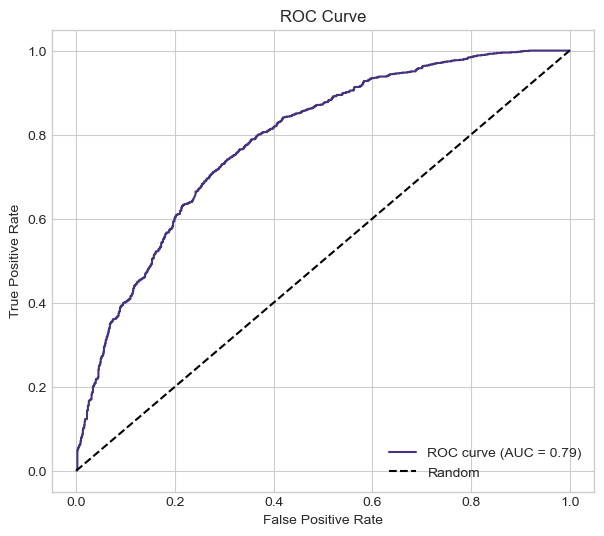

In [121]:
tuned_svm_model = AugmentedFeatureModel(
    image_dir='./data/patch_images',
    classifier_name='tuned_binary_lr',
    classifier= SVC(
        random_state=42,
        kernel=svm_bin_gs_params['classifier__kernel'],
        probability=True
    )
)
tuned_svm_model.fit(is_cancerous_train[['ImageName']], is_cancerous_train[['isCancerous']])
results = evaluate_binary_classifier(
    tuned_svm_model, 
    x_is_cancerous_test, 
    y_is_cancerous_test,
    class_names=["0", "1"],
    model_name='SVM'
)

In [122]:
results

,model,f1_weighted,precision_weighted,recall_weighted,auc,precision_0,recall_0,precision_1,recall_1
0,Binary Logistic Regression,0.697306,0.713430,0.702068,0.797983,0.666416,0.823584,0.761606,0.577545
1,Random Forest,0.697379,0.713233,0.702068,0.797860,0.666667,0.822656,0.760951,0.578497
2,SVM,0.662206,0.694794,0.672932,0.785651,0.632017,0.846797,0.759124,0.494767


In [123]:
metrics = [col for col in results.columns if col != "model"]

summary = pd.DataFrame({
    "Best Model": results.set_index('model')[metrics].idxmax(),
    "Best Score": results.set_index('model')[metrics].max()
})
summary = summary.reset_index().rename(columns={"index": "Metric"})
print(summary)

               Metric                  Best Model  Best Score
0         f1_weighted               Random Forest    0.697379
1  precision_weighted  Binary Logistic Regression    0.713430
2     recall_weighted  Binary Logistic Regression    0.702068
3                 auc  Binary Logistic Regression    0.797983
4         precision_0               Random Forest    0.666667
5            recall_0                         SVM    0.846797
6         precision_1  Binary Logistic Regression    0.761606
7            recall_1               Random Forest    0.578497


**Evaluation for traditional algorithms**: Based on the result, SVM is the baseline method since it has the best performance for all metrics.

#### Development for deep learning approach

In [124]:
# Split your data into 1 train-val split using fold 0 from PatientClassKFold
splitter = PatientClassKFold(n_splits=5, random_state=42)
splits = list(splitter.split(is_cancerous_train, patient_col='patientID', class_col='isCancerous'))

# Pick the first fold for validation
train_idx, val_idx = splits[0]

nn_train_is_cancerous = is_cancerous_train.iloc[train_idx].reset_index(drop=True)
nn_val_is_cancerous = is_cancerous_train.iloc[val_idx].reset_index(drop=True)

# Confirm class distribution
print("Train class distribution:\n", nn_train_is_cancerous['isCancerous'].value_counts())
print("\nVal class distribution:\n", nn_val_is_cancerous['isCancerous'].value_counts())

# Confirm no patient overlap
train_patients = set(nn_train_is_cancerous['patientID'])
val_patients = set(nn_val_is_cancerous['patientID'])
overlap = train_patients.intersection(val_patients)

if overlap:
    print(f"Data leakage detected: {overlap}")
else:
    print("No data leakage: train and validation sets are clean.")

Train class distribution:
 isCancerous
0    4025
1    2411
Name: count, dtype: int64

Val class distribution:
 isCancerous
0    715
1    617
Name: count, dtype: int64
No data leakage: train and validation sets are clean.


Similar to the traditional ML, a separate class is created for training the neural network

In [125]:
# This class is created to handle the data augmentation during the training.
class NeuralNetworkAugmentedImageModel:
    def __init__(self, image_dir, model, class_names, random_state=42, classifier_name="neural_net"):
        self.image_dir = image_dir
        self.model = model
        self.random_state = random_state
        self.class_names = class_names
        self.image_aug_dir = f'./data/aug/{classifier_name}'
        os.makedirs(self.image_aug_dir, exist_ok=True)
        self.classifier_name = classifier_name
        
    # Function to create the augmented images and save to the disk. We used the oversampling technique to
    # handle the imbalance class issue
    def _augment_and_resample(self, X, y):
        self.augmentor = CustomDataAugmentor()
        import uuid
        from PIL import Image
        df = X.copy()
        df['label'] = y
    
        counts = df['label'].value_counts()
        max_count = counts.max()
        balanced_rows = []
    
        for label in counts.index:
            samples = df[df['label'] == label]
            n_samples = samples.shape[0]
            required = max_count - n_samples
            print("N required: " + str(required))
            sampled = samples.sample(n=required, replace=True, random_state=self.random_state)
    
            for _, row in sampled.iterrows():
                image_path = os.path.join(self.image_dir, row['ImageName'])
                original = load_img(image_path)
                x = img_to_array(original)
                x = x.reshape((1,) + x.shape)
                aug_iter = self.augmentor.flow(x, batch_size=1, shuffle=False)
                aug_image = next(aug_iter)[0] * 255.0
    
                # Save augmented image to the same directory
                aug_fname = f"aug_{uuid.uuid4().hex[:8]}.png"
                aug_fpath = os.path.join(self.image_aug_dir, aug_fname)
                Image.fromarray(aug_image.astype(np.uint8)).save(aug_fpath)
    
                balanced_rows.append({'ImageName': aug_fname, 'label': label})
    
            # Copy original images into the same folder and track
            for _, row in samples.iterrows():
                src_path = os.path.join(self.image_dir, row['ImageName'])
                dst_path = os.path.join(self.image_aug_dir, row['ImageName'])
                if not os.path.exists(dst_path):
                    shutil.copy(src_path, dst_path)
                balanced_rows.append({'ImageName': row['ImageName'], 'label': label})
    
        df_balanced = pd.DataFrame(balanced_rows)
        return df_balanced


    def train(self, X, y, batch_size=32, epochs=50, validation_data=None, verbose=0, callbacks=[], cleanup_after_training=True):
        df_balanced = self._augment_and_resample(X, y)
        print("Class distribution after balancing:")
        print(df_balanced['label'].value_counts())
        train_gen = ImageDataGenerator(rescale=1. / 255).flow_from_dataframe(
            dataframe=df_balanced,
            directory= self.image_aug_dir,
            x_col='ImageName',
            y_col='label',
            target_size=(27, 27),
            batch_size=batch_size,
            class_mode='categorical',
            shuffle=True,
            classes=self.class_names
        )

        val_gen = None
        if validation_data:
            X_val, y_val = validation_data
            val_df = X_val.copy()
            val_df['label'] = y_val
            val_gen = ImageDataGenerator(rescale=1. / 255).flow_from_dataframe(
                dataframe=val_df,
                directory=self.image_dir,
                x_col='ImageName',
                y_col='label',
                target_size=(27, 27),
                batch_size=batch_size,
                class_mode='categorical',
                shuffle=True,
                classes=self.class_names
            )
            validation_steps = math.ceil(len(val_df) / batch_size)

        steps_per_epoch = math.ceil(len(df_balanced) / batch_size)
        self.train_history = self.model.fit(
            train_gen,
            # steps_per_epoch=steps_per_epoch,
            validation_data=val_gen,
            # validation_steps=validation_steps,
            epochs=epochs,
            verbose=1,
            callbacks=callbacks
        )
        if cleanup_after_training:
            print(f"🧹 Deleting augmented image directory: {self.image_aug_dir}")
            shutil.rmtree(self.image_aug_dir, ignore_errors=True)

        return self

    def predict(self, X):
        df = X.copy()
        df['label'] = 'unknown'  # dummy
        pred_gen = ImageDataGenerator(rescale=1. / 255).flow_from_dataframe(
            dataframe=df,
            directory=self.image_dir,
            x_col='ImageName',
            y_col='label',
            target_size=(27, 27),
            batch_size=32,
            class_mode=None,
            shuffle=False,
        )
        
        preds = self.model.predict(pred_gen)
        return [self.class_names[i] for i in np.argmax(preds, axis=1)]

    def predict_proba(self, X):
        df = X.copy()
        df['label'] = 'unknown'
        pred_gen = ImageDataGenerator(rescale=1. / 255).flow_from_dataframe(
            dataframe=df,
            directory=self.image_dir,
            x_col='ImageName',
            y_col='label',
            target_size=(27, 27),
            batch_size=32,
            class_mode=None,
            shuffle=False,
        )
        return self.model.predict(pred_gen)

    def classes_(self):
        return self.class_names

    def load_best_model(self, path):
        """Load a saved Keras model from disk and update self.model."""
        self.model =  tf.keras.models.load_model(path)
        print(f"Loaded best model from: {path}")


In [126]:
def plot_train_val_loss(history):
    sns.set(style="whitegrid")
    plt.figure(figsize=(6, 4))

    sns.lineplot(x=range(len(history['loss'])), y=history['loss'], label='train', linestyle='--', color='red')
    sns.lineplot(x=range(len(history['val_loss'])), y=history['val_loss'], label='val', linestyle='--', color='blue')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss")

    plt.tight_layout()
    plt.show()

#### Aritifical Neural Network (MLP)

In [127]:
input_shape = (27, 27, 3)
is_cancerous_n_classes = 2
is_cancerous_classes = ['0','1']

In [128]:
# Assuming you have a compiled Keras model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dense, Flatten, Dropout, Input

def train_nn_for_is_cancerous_task(
    model,
    optimizer,
    epochs,
    batch_size,
    callbacks,
    train_df,
    val_df
):
    model.compile(
        optimizer=optimizer, 
        loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
        metrics=[
            'categorical_accuracy',
            Precision(name='precision'),
            Recall(name='recall')
        ]
    )
    nn_model_with_aug = NeuralNetworkAugmentedImageModel(
        image_dir='./data/patch_images',
        model=model,
        class_names=is_cancerous_classes
    )

    ann_model = nn_model_with_aug.train(
        X=train_df[['ImageName']],
        y=train_df['isCancerous'].astype(str),
        validation_data=(val_df[['ImageName']], val_df['isCancerous'].astype(str)),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=callbacks
    )

    return ann_model


In [129]:
is_cancerous_ann = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=input_shape),
    tf.keras.layers.Flatten(),  # Converts 27x27x3 → 2187 vector
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(is_cancerous_n_classes, activation='sigmoid')
])
is_cancerous_ann.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 2187)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       280,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 280,322 (1.07 MB)

 Trainable params: 280,322 (1.07 MB)

 Non-trainable params: 0 (0.00 B)

In [130]:
trained_model_ann = train_nn_for_is_cancerous_task(
    model=is_cancerous_ann,
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    epochs=50,
    batch_size=32,
    callbacks=[],
    train_df=nn_train_is_cancerous,
    val_df=nn_val_is_cancerous
)

N required: 0
N required: 1614
Class distribution after balancing:
label
0    4025
1    4025
Name: count, dtype: int64
Found 8050 validated image filenames belonging to 2 classes.
Found 1332 validated image filenames belonging to 2 classes.
Epoch 1/50


/opt/anaconda3/envs/cosc2820/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2025-05-19 01:18:02.824146: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2025-05-19 01:18:02.826879: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


252/252 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - categorical_accuracy: 0.7399 - loss: 0.8161 - precision: 0.5602 - recall: 0.9454 - val_categorical_accuracy: 0.7748 - val_loss: 0.4794 - val_precision: 0.5132 - val_recall: 0.9940
Epoch 2/50
 62/252 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - categorical_accuracy: 0.8490 - loss: 0.3731 - precision: 0.5953 - recall: 0.9964 Deleting augmented image directory: ./data/aug/aug_bin_logistic_clf_93b02e
 Deleting augmented image directory: ./data/aug/aug_bin_logistic_clf_40b6d7
 Deleting augmented image directory: ./data/aug/aug_bin_rf_clf_f2cae2
 Deleting augmented image directory: ./data/aug/aug_bin_rf_clf_55f8e4
 Deleting augmented image directory: ./data/aug/aug_bin_rf_clf_33bbd7
 Deleting augmented image directory: ./data/aug/aug_bin_rf_clf_516901
108/252 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - categorical_accuracy: 0.8593 - loss: 0.3487 - precision: 0.5957 - recall: 0.9966 Deleting augmented image directory: ./data/aug/aug_bin_logistic_clf_c78097
 Deleting

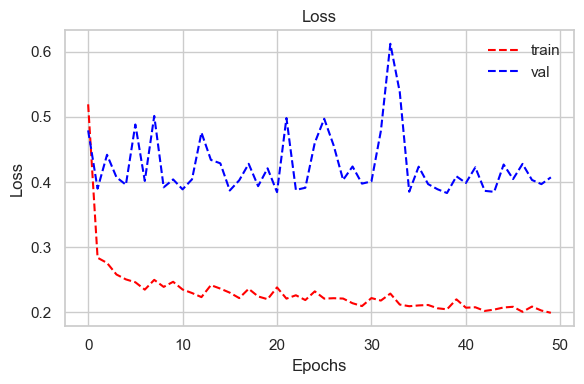

In [131]:
plot_train_val_loss(trained_model_ann.train_history.history)

Based on the given chart, the model is overfit and the training is not stable, so both L2 is used to handle overfit and BatchNormalization is used to stablilize the training.

In [132]:
is_cancerous_overfit_ann = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=input_shape),
    tf.keras.layers.Flatten(),  # Converts 27x27x3 → 2187 vector
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    # since binary classification, sigmoid is used in the las layer
    tf.keras.layers.Dense(is_cancerous_n_classes, activation='sigmoid')
])
is_cancerous_overfit_ann.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)             │ (None, 2187)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       280,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 280,834 (1.07 MB)

 Trainable params: 280,578 (1.07 MB)

 Non-trainable params: 256 (1.00 KB)

In [133]:
is_cancerous_overfit_ann_model = train_nn_for_is_cancerous_task(
    model=is_cancerous_overfit_ann,
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    epochs=50,
    batch_size=32,
    callbacks=[],
    train_df=nn_train_is_cancerous,
    val_df=nn_val_is_cancerous
)

N required: 0
N required: 1614
Class distribution after balancing:
label
0    4025
1    4025
Name: count, dtype: int64
Found 8050 validated image filenames belonging to 2 classes.
Found 1332 validated image filenames belonging to 2 classes.
Epoch 1/50


/opt/anaconda3/envs/cosc2820/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2025-05-19 01:21:58.038462: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


252/252 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - categorical_accuracy: 0.8461 - loss: 0.5312 - precision: 0.8501 - recall: 0.8196 - val_categorical_accuracy: 0.4632 - val_loss: 1.5853 - val_precision: 0.5394 - val_recall: 0.6321
Epoch 2/50
252/252 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - categorical_accuracy: 0.8996 - loss: 0.3824 - precision: 0.8616 - recall: 0.9310 - val_categorical_accuracy: 0.4842 - val_loss: 1.4714 - val_precision: 0.4834 - val_recall: 0.4805
Epoch 3/50
252/252 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - categorical_accuracy: 0.9026 - loss: 0.3197 - precision: 0.9131 - recall: 0.8913 - val_categorical_accuracy: 0.7943 - val_loss: 0.4976 - val_precision: 0.7688 - val_recall: 0.8611
Epoch 4/50
252/252 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - categorical_accuracy: 0.9011 - loss: 0.2935 - precision: 0.8985 - recall: 0.9012 - val_categorical_accuracy: 0.5435 - val_loss: 1.2625 - val_precision: 0.5441 - val_recall: 0.5465
Epoch 5/50
252/252 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - categorical_accu

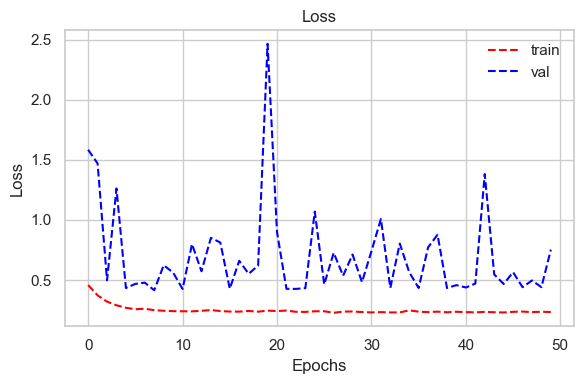

In [134]:
plot_train_val_loss(is_cancerous_overfit_ann_model.train_history.history)

The loss graph depicts the model is good fit, so we chose this model as the final one.

Found 2128 validated image filenames.
 8/67 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 

/opt/anaconda3/envs/cosc2820/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2025-05-19 01:27:13.554449: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Found 2128 validated image filenames.
19/67 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

/opt/anaconda3/envs/cosc2820/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.40      0.57      1077
           1       0.62      0.99      0.76      1051

    accuracy                           0.69      2128
   macro avg       0.79      0.70      0.67      2128
weighted avg       0.80      0.69      0.66      2128

Confusion Matrix:


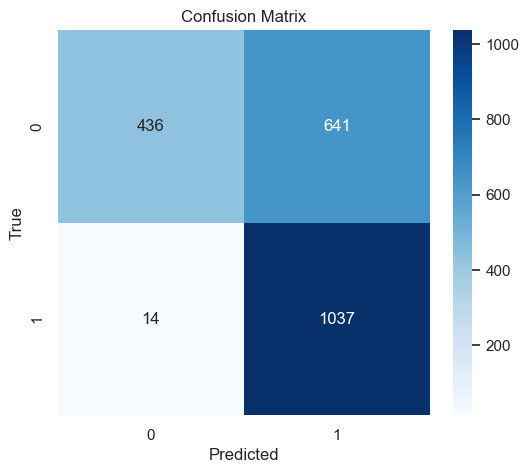

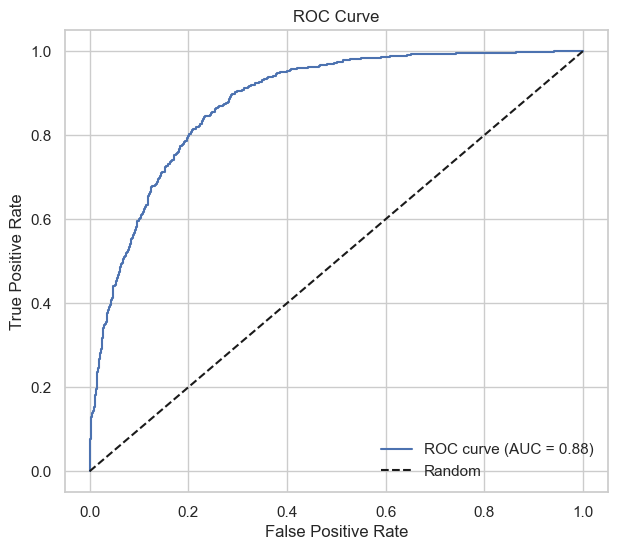

In [135]:
results = evaluate_binary_classifier(
    is_cancerous_overfit_ann_model, 
    x_is_cancerous_test, 
    y_is_cancerous_test,
    class_names=['0', '1'],
    model_name='ANN'
)

In [136]:
results

,model,f1_weighted,precision_weighted,recall_weighted,auc,precision_0,recall_0,precision_1,recall_1
0,Binary Logistic Regression,0.697306,0.713430,0.702068,0.797983,0.666416,0.823584,0.761606,0.577545
1,Random Forest,0.697379,0.713233,0.702068,0.797860,0.666667,0.822656,0.760951,0.578497
2,SVM,0.662206,0.694794,0.672932,0.785651,0.632017,0.846797,0.759124,0.494767
3,ANN,0.664366,0.795587,0.692199,0.881972,0.968889,0.404828,0.617998,0.986679


In [137]:
metrics = [col for col in results.columns if col != "model"]

summary = pd.DataFrame({
    "Best Model": results.set_index('model')[metrics].idxmax(),
    "Best Score": results.set_index('model')[metrics].max()
})
summary = summary.reset_index().rename(columns={"index": "Metric"})
print(summary)

               Metric                  Best Model  Best Score
0         f1_weighted               Random Forest    0.697379
1  precision_weighted                         ANN    0.795587
2     recall_weighted  Binary Logistic Regression    0.702068
3                 auc                         ANN    0.881972
4         precision_0                         ANN    0.968889
5            recall_0                         SVM    0.846797
6         precision_1  Binary Logistic Regression    0.761606
7            recall_1                         ANN    0.986679


**Recommend approach**: 
Based on the table, the ANN model wins **5/8** of the metrics, it has the highest AUC and recall (catching all cancer cases, especially minimizing false negatives). Therefore ANN is the recommended model. However, as working in medical industry, this model should be deployed with other techniques to ensure the transparency or explainability.

In [249]:
# Code to perform the final test on a random image.
random_row_img = is_cancerous_test.sample(n=1, random_state=42)
predicted_label = is_cancerous_overfit_ann_model.predict(random_row_img)
predicted_label_prob = is_cancerous_overfit_ann_model.predict_proba(random_row_img)
print(f"True label is: {random_row_img['isCancerous'].values[0]}")
print(f"Predicted label is: {predicted_label[0]}")


Found 1 validated image filenames.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
Found 1 validated image filenames.


/opt/anaconda3/envs/cosc2820/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/opt/anaconda3/envs/cosc2820/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
True label is: 1
Predicted label is: 1


### Task B: Cell type classification

The objective of this task is to classify the cell type. The task can be abstract as **multiclass classification** using image. Beside the common metric listed above, some other metrics are used, including:
- One-vs-Rest AUC-ROC: Multiple curves (one per class) 
- Precision and Recall metrics for each cell type to identify per-class performance issues
In this task, due to the report length and time limitation of the assignment, we only selected the Logistic Regression for traditional machine learning as the baseline due to its simplicity for the classification task. Also, explore more on CNN architecture as it perform well on image dataset.

In [147]:
cell_type_train = pd.read_csv('./data/cell_type_train.csv')
cell_type_test = pd.read_csv('./data/cell_type_test.csv')
x_cell_type_test = cell_type_test[['ImageName']]
y_cell_type_test = cell_type_test['cellType']

model_eval_results = []

In [148]:
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_curve,
    auc,
    f1_score,
    precision_score,
    recall_score
)
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Global list to hold results
model_eval_results = []

def evaluate_multiclass_classifier(model, X_test, y_test, class_names=None, model_name="Model"):
    """
    Evaluate a multi-class classifier.
    Computes precision, recall, AUC (one-vs-rest), plots ROC curves,
    appends results to model_eval_results, and returns a DataFrame.
    
    Parameters:
    -----------
    model : estimator object
        The classifier with predict and predict_proba methods
    X_test : array-like
        Test features
    y_test : array-like
        True labels (integers from 0 to n_classes-1)
    class_names : list, optional
        List of class names matching label indices
    model_name : str, optional
        Name to identify the model in results
        
    Returns:
    --------
    pd.DataFrame : DataFrame with evaluation metrics
    """
    y_pred = model.predict(X_test)
    y_score = model.predict_proba(X_test)
    y_pred = np.array(y_pred).astype(int)
    y_test = np.array(y_test).astype(int)
    print(y_pred)
    print(y_test)
    # Determine class names if not provided
    unique_labels = np.unique(y_test)
    n_classes = len(unique_labels)
    
    if class_names is None:
        class_names = [f"Class {i}" for i in range(n_classes)]
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred, labels=unique_labels)
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=class_names))
    
    print("Confusion Matrix:")
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()
    
    # One-hot encode y_test for ROC AUC
    y_test_bin = label_binarize(y_test, classes=unique_labels)
    
    # Calculate ROC curve and AUC for each class
    plt.figure(figsize=(8, 6))
    roc_auc_scores = {}
    for i, class_name in enumerate(class_names):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        class_auc = auc(fpr, tpr)
        roc_auc_scores[class_name] = class_auc
        plt.plot(fpr, tpr, lw=2, label=f'{class_name} (AUC = {class_auc:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - Multi-class')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()
    
    # Calculate precision and recall per class
    precision = precision_score(y_test, y_pred, average=None, labels=unique_labels)
    recall = recall_score(y_test, y_pred, average=None, labels=unique_labels)
    
    # Prepare results dictionary
    results = {
        "model": model_name,
        "f1_weighted": f1_score(y_test, y_pred, average='weighted'),
        "precision_weighted": precision_score(y_test, y_pred, average='weighted'),
        "recall_weighted": recall_score(y_test, y_pred, average='weighted')
    }
    
    # Add per-class precision, recall, AUC
    for i, class_name in enumerate(class_names):
        results[f"precision_{class_name}"] = precision[i]
        results[f"recall_{class_name}"] = recall[i]
        results[f"auc_{class_name}"] = roc_auc_scores[class_name]
    
    # Append to global results list
    model_eval_results.append(results)
    
    # Return DataFrame of all evaluations so far
    return pd.DataFrame(model_eval_results)


In [149]:
# This function is used to extract the features, when training the data
class CellTypeImageFeatureExtractor:
    def process_and_extract_features(self, image_path, title=""):
        # Load and preprocess image
        image = imread(image_path)
        grayscale = rgb2gray(image)
        grayscale = (grayscale * 255).astype(np.uint8) 
    
        # Sobel edge detection
        smooth_gray = gaussian(grayscale, sigma=1) # when setting to sigma to higher value, most of features is gone
        edge_h = filters.sobel_h(smooth_gray)
        edge_v = filters.sobel_v(smooth_gray)
        edge_magnitude = np.sqrt(edge_h**2 + edge_v**2)
        edge_mean = edge_magnitude.mean()
        edge_std = edge_magnitude.std()
    
        # LBP feature extraction
        radius = 1
        n_points = 8 * radius
        lbp = local_binary_pattern(grayscale, n_points, radius, method='uniform')
    
        # Normalize LBP histogram as feature vector
        lbp_hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))
        lbp_hist = lbp_hist.astype('float')
        lbp_hist /= (lbp_hist.sum() + 1e-6)  # Avoid divide by zero
    
        # Extract color features (mean and std of RGB channels)
        mean_r = np.mean(image[:, :, 0])
        mean_g = np.mean(image[:, :, 1])
        mean_b = np.mean(image[:, :, 2])
        std_r = np.std(image[:, :, 0])
        std_g = np.std(image[:, :, 1])
        std_b = np.std(image[:, :, 2])
        
        # Extract shape features (area, perimeter, eccentricity, etc.)
        # Combine all features into one vector
        full_features = np.hstack([
            lbp_hist,
            [mean_r, mean_g, mean_b, std_r, std_g, std_b],
            [edge_mean, edge_std]
        ])
    
        return full_features


In [150]:
cell_type_train.head()

,InstanceID,patientID,ImageName,cellTypeName,cellType
0,19035,2,19035.png,fibroblast,0
1,19036,2,19036.png,fibroblast,0
2,19037,2,19037.png,fibroblast,0
3,19038,2,19038.png,fibroblast,0
4,19039,2,19039.png,fibroblast,0


In [151]:
kf = PatientClassKFold(n_splits=5, random_state=42)

all_classes = set(cell_type_train['cellType'].unique())

for fold, (train_idx, val_idx) in enumerate(kf.split(cell_type_train, patient_col='patientID', class_col='cellType')):
    train_fold = cell_type_train.iloc[train_idx].reset_index(drop=True)
    val_fold = cell_type_train.iloc[val_idx].reset_index(drop=True)

    train_patients = set(train_fold['patientID'].unique())
    val_patients = set(val_fold['patientID'].unique())

    # Check for patient leakage
    patient_intersection = train_patients.intersection(val_patients)
    if patient_intersection:
        print(f"WARNING: Data leakage detected in fold {fold + 1}! Patients in both train and val: {patient_intersection}")
    else:
        print(f"Fold {fold + 1}: No patient leakage detected.")

    # Check class coverage
    train_classes = set(train_fold['cellType'].unique())
    val_classes = set(val_fold['cellType'].unique())

    missing_in_train = all_classes - train_classes
    missing_in_val = all_classes - val_classes

    print(f"Fold {fold + 1} train classes count: {len(train_classes)} (missing: {missing_in_train if missing_in_train else 'None'})")
    print(f"Fold {fold + 1} val classes count: {len(val_classes)} (missing: {missing_in_val if missing_in_val else 'None'})")

    print(f"Number of unique patients in train: {len(train_patients)}")
    print(f"Number of unique patients in val: {len(val_patients)}")
    print("-" * 40)


Fold 1: No patient leakage detected.
Fold 1 train classes count: 4 (missing: None)
Fold 1 val classes count: 4 (missing: None)
Number of unique patients in train: 38
Number of unique patients in val: 10
----------------------------------------
Fold 2: No patient leakage detected.
Fold 2 train classes count: 4 (missing: None)
Fold 2 val classes count: 4 (missing: None)
Number of unique patients in train: 38
Number of unique patients in val: 10
----------------------------------------
Fold 3: No patient leakage detected.
Fold 3 train classes count: 4 (missing: None)
Fold 3 val classes count: 4 (missing: None)
Number of unique patients in train: 38
Number of unique patients in val: 10
----------------------------------------
Fold 4: No patient leakage detected.
Fold 4 train classes count: 4 (missing: None)
Fold 4 val classes count: 4 (missing: None)
Number of unique patients in train: 39
Number of unique patients in val: 9
----------------------------------------
Fold 5: No patient leakag

In [152]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.linear_model import LogisticRegression
from sklearn.utils.validation import check_X_y, check_array
from sklearn.preprocessing import LabelEncoder
import numpy as np
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
import shutil
import uuid


class CellTypeAugmentedFeatureModel(BaseEstimator, ClassifierMixin):
    def __init__(self, image_dir, classifier_name, classifier=None, random_state=42):
        self.image_dir = image_dir
        self.classifier = classifier if classifier is not None else LogisticRegression(max_iter=1000)
        self.random_state = random_state
        self.augment_times = 1
       
        self.classifier_name = classifier_name
        self.clean_up = True

        # Define augmentation strategy
        

    def _augment_and_resample(self, X, y):
        import uuid
        df = X.copy()
        df['label'] = y
        self.augmentor = CustomDataAugmentor()
        counts = df['label'].value_counts()
        max_count = counts.max()
        balanced_rows = []
    
        for label in counts.index:
            samples = df[df['label'] == label]
            n_samples = samples.shape[0]
            required = max_count - n_samples
            sampled = samples.sample(n=required, replace=True, random_state=self.random_state)
    
            for _, row in sampled.iterrows():
                image_path = os.path.join(self.image_dir, row['ImageName'])
                original = load_img(image_path)
                x = img_to_array(original)
                x = x.reshape((1,) + x.shape)
                aug_iter = self.augmentor.flow(x, batch_size=1, shuffle=False)
                aug_image = next(aug_iter)[0] * 255.0
    
                # Save augmented image temporarily
                aug_fname = f"aug_{uuid.uuid4().hex[:8]}.png"
                aug_fpath = os.path.join(self.image_aug_dir, aug_fname)
                from PIL import Image
                Image.fromarray(aug_image.astype(np.uint8)).save(aug_fpath)
    
                balanced_rows.append({'ImageName': aug_fpath, 'label': label})
    
             # Copy original images into the same folder and track
            for _, row in samples.iterrows():
                src_path = os.path.join(self.image_dir, row['ImageName'])
                dst_path = os.path.join(self.image_aug_dir, row['ImageName'])
                if not os.path.exists(dst_path):
                    shutil.copy(src_path, dst_path)
                balanced_rows.append({'ImageName': dst_path, 'label': label})
    
        df_balanced = pd.DataFrame(balanced_rows)
        return df_balanced[['ImageName']], df_balanced['label']


    def _extract_features(self, X_df, use_name_only=False):
        self.feature_extractor = CellTypeImageFeatureExtractor()
        features = []
        for fname in X_df['ImageName']:
            if use_name_only is True:
                fname = os.path.join(self.image_dir, fname)
            feat = self.feature_extractor.process_and_extract_features(fname)
            features.append(feat)
        return np.array(features)

    def fit(self, X, y):
        # Augment + extract features
        self.instance_id = uuid.uuid4().hex[:6]
        self.image_aug_dir = f'./data/aug/{self.classifier_name}_{self.instance_id}'
        os.makedirs(self.image_aug_dir, exist_ok=True)
        
        X = X.copy()
        X_balanced, y_balanced = self._augment_and_resample(X, y)
        self.le_ = LabelEncoder().fit(y_balanced)
        y_encoded = self.le_.transform(y_balanced)
        X_features = self._extract_features(X_balanced, False)
        self.classes_ = self.le_.classes_
        self.classifier.fit(X_features, y_encoded)
        if self.clean_up:
            print(f"🧹 Deleting augmented image directory: {self.image_aug_dir}")
            shutil.rmtree(self.image_aug_dir)
        return self

    def predict(self, X):
        X_features = self._extract_features(X, True)
        print("start predict")
        # print(X_features[0])
        y_pred = self.classifier.predict(X_features)
        return self.le_.inverse_transform(y_pred)

    def predict_proba(self, X):
        X_features = self._extract_features(X, True)
        return self.classifier.predict_proba(X_features)

    def score(self, X, y):
        y_pred = self.predict(X)
        print(len(y_pred))
        print(len(y))
        return np.mean(y_pred == y)


#### Logistic Regression

In [154]:
lr_init__model = AugmentedFeatureModel(
    image_dir='./data/patch_images',
    classifier_name='bin_lr_init',
    classifier=LogisticRegression(max_iter=100000, multi_class='multinomial')
)
perform_cv_on_baseline_model(lr_init__model, cell_type_train[['ImageName']], cell_type_train['cellType'], 'cellType')

 Deleting augmented image directory: ./data/aug/bin_lr_init_0dcacd
Fold 1: Weighted F1 = 0.6771
 Deleting augmented image directory: ./data/aug/bin_lr_init_efb2e6
Fold 2: Weighted F1 = 0.7868
 Deleting augmented image directory: ./data/aug/bin_lr_init_9c7348
Fold 3: Weighted F1 = 0.7042
 Deleting augmented image directory: ./data/aug/bin_lr_init_a803d9
Fold 4: Weighted F1 = 0.7230
 Deleting augmented image directory: ./data/aug/bin_lr_init_df491f
Fold 5: Weighted F1 = 0.6930

Average Weighted F1 Score: 0.7168
Mean CV score: 0.7168
Standard deviation: 0.0381


In [167]:
folds = list(kf.split(cell_type_train, patient_col='patientID', class_col='cellType'))
lr_bin_gs_params = evaluate_model_with_cv(
    model=LogisticRegression(max_iter=100000, multi_class='multinomial'),
    model_name="aug_bin_logistic_clf",
    param_grid = {
        'classifier__C': [0.01, 0.1, 1, 10]
    },
    image_dir='./data/patch_images',
    df_train=cell_type_train,
    folds=folds,
    label_column='cellType'
)

TypeError: evaluate_model_with_cv() missing 1 required positional argument: 'df_test'

 Deleting augmented image directory: ./data/aug/tuned_binary_lr_40ad49
[0 0 1 ... 2 2 2]
[0 0 0 ... 2 2 2]

📄 Classification Report:
              precision    recall  f1-score   support

           0       0.38      0.41      0.40       307
           1       0.72      0.76      0.74       618
           2       0.72      0.77      0.74      1051
           3       0.27      0.04      0.07       152

    accuracy                           0.66      2128
   macro avg       0.52      0.50      0.49      2128
weighted avg       0.64      0.66      0.65      2128

📊 Confusion Matrix:


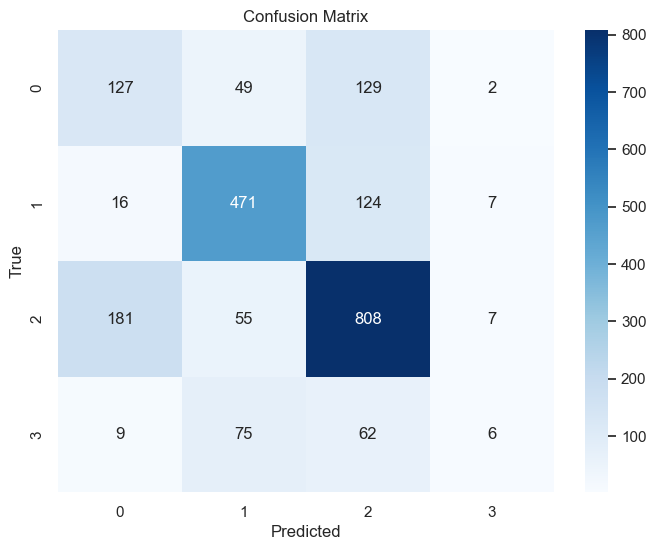

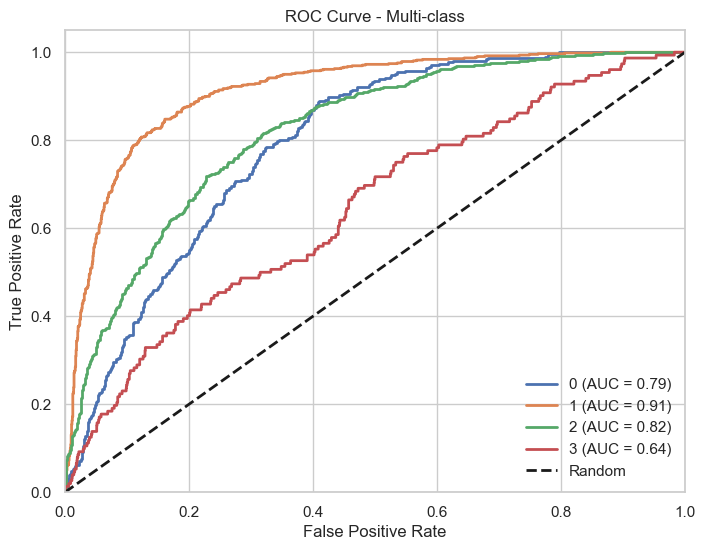

In [162]:
tuned_lr_model = AugmentedFeatureModel(
    image_dir='./data/patch_images',
    classifier_name='tuned_binary_lr',
    classifier=LogisticRegression(max_iter=100000, C=lr_bin_gs_params['classifier__C'])
)
tuned_lr_model.fit(cell_type_train[['ImageName']], cell_type_train[['cellType']])
lr_test_result = evaluate_multiclass_classifier(
    tuned_lr_model,
    x_cell_type_test,
    y_cell_type_test,
    class_names=["0", "1", "2", "3"],
    model_name='Multiclass Logistic Regression'
)

lr_test_result

#### Random forest

In [164]:
rf_init__model = AugmentedFeatureModel(
    image_dir='./data/patch_images',
    classifier_name='bin_rf_init',
    classifier= RandomForestClassifier(random_state=42)
)
perform_cv_on_baseline_model(rf_init__model, cell_type_train[['ImageName']], cell_type_train['cellType'], 'cellType')

 Deleting augmented image directory: ./data/aug/bin_rf_init_012bbb
Fold 1: Weighted F1 = 0.6800
 Deleting augmented image directory: ./data/aug/bin_rf_init_fdf442
Fold 2: Weighted F1 = 0.8042
 Deleting augmented image directory: ./data/aug/bin_rf_init_8c19a3
Fold 3: Weighted F1 = 0.7476
 Deleting augmented image directory: ./data/aug/bin_rf_init_4d942f
Fold 4: Weighted F1 = 0.7070
 Deleting augmented image directory: ./data/aug/bin_rf_init_8dae2e
Fold 5: Weighted F1 = 0.7193

Average Weighted F1 Score: 0.7316
Mean CV score: 0.7316
Standard deviation: 0.0423


In [171]:
folds = list(kf.split(cell_type_train, patient_col='patientID', class_col='cellType'))

rf_bin_gs_params = evaluate_model_with_cv(
    model= RandomForestClassifier(random_state=42),
    model_name="aug_bin_rf_clf",
    param_grid = {
        'classifier__max_depth': [10, 20],
        'classifier__min_samples_split': [2, 5, 10],
    },
    image_dir='./data/patch_images',
    df_train=cell_type_train,
    folds=folds,
    label_column='cellType'
)

Starting Grid Search...
Fitting 5 folds for each of 6 candidates, totalling 30 fits
 Deleting augmented image directory: ./data/aug/aug_bin_rf_clf_f00f3f
Best score: 0.5194314946713441
[{'classifier__max_depth': 10, 'classifier__min_samples_split': 2}, {'classifier__max_depth': 10, 'classifier__min_samples_split': 5}, {'classifier__max_depth': 10, 'classifier__min_samples_split': 10}, {'classifier__max_depth': 20, 'classifier__min_samples_split': 2}, {'classifier__max_depth': 20, 'classifier__min_samples_split': 5}, {'classifier__max_depth': 20, 'classifier__min_samples_split': 10}]
Best params: {'classifier__max_depth': 20, 'classifier__min_samples_split': 10}


 Deleting augmented image directory: ./data/aug/tuned_binary_lr_ed4d7e
[0 0 1 ... 2 2 2]
[0 0 0 ... 2 2 2]

📄 Classification Report:
              precision    recall  f1-score   support

           0       0.40      0.46      0.43       307
           1       0.74      0.76      0.75       618
           2       0.73      0.78      0.75      1051
           3       0.23      0.04      0.07       152

    accuracy                           0.67      2128
   macro avg       0.53      0.51      0.50      2128
weighted avg       0.65      0.67      0.66      2128

📊 Confusion Matrix:


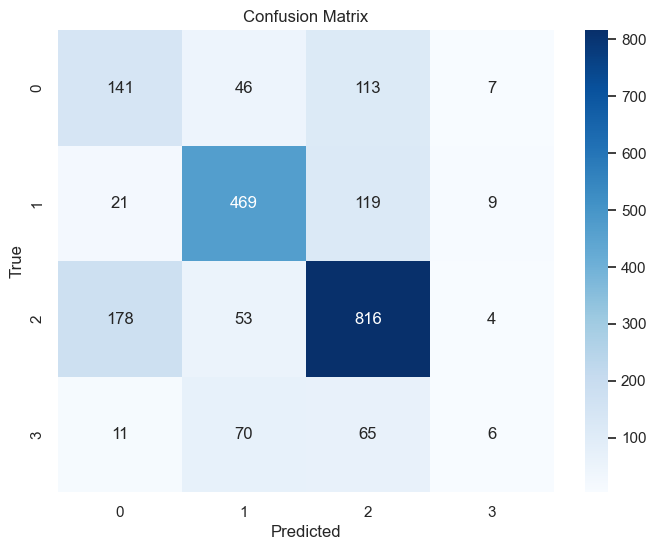

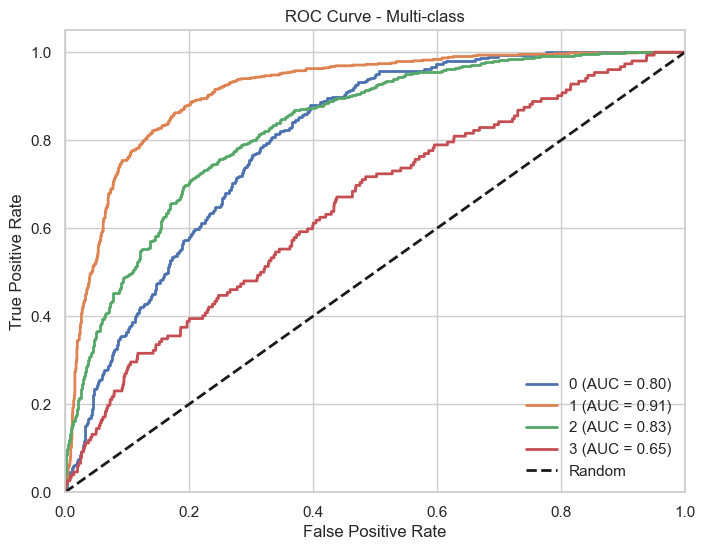

,model,f1_weighted,precision_weighted,recall_weighted,precision_0,recall_0,auc_0,precision_1,recall_1,auc_1,precision_2,recall_2,auc_2,precision_3,recall_3,auc_3
0,Random Forest,0.656002,0.650021,0.672932,0.401709,0.459283,0.8006,0.73511,0.7589,0.911819,0.733154,0.776403,0.831304,0.230769,0.039474,0.649037


In [172]:
tuned_rf_model = AugmentedFeatureModel(
    image_dir='./data/patch_images',
    classifier_name='tuned_binary_lr',
    classifier=RandomForestClassifier(
        random_state=42,
        max_depth=rf_bin_gs_params['classifier__max_depth'],
        min_samples_split=rf_bin_gs_params['classifier__min_samples_split'],
    )
)
tuned_lr_model.fit(cell_type_train[['ImageName']], cell_type_train[['cellType']])
evaluate_multiclass_classifier(
    tuned_lr_model, 
    x_cell_type_test,
    y_cell_type_test, 
    class_names=["0", "1", "2", "3"],
    model_name='Random Forest'
)

#### Support Vector Machine

In [173]:
svm_init__model = AugmentedFeatureModel(
    image_dir='./data/patch_images',
    classifier_name='bin_svm_init',
    classifier= SVC(random_state=42)
)
perform_cv_on_baseline_model(svm_init__model, cell_type_train[['ImageName']], cell_type_train['cellType'], 'cellType')

 Deleting augmented image directory: ./data/aug/bin_svm_init_1979a0
Fold 1: Weighted F1 = 0.5627
 Deleting augmented image directory: ./data/aug/bin_svm_init_b729e8
Fold 2: Weighted F1 = 0.7111
 Deleting augmented image directory: ./data/aug/bin_svm_init_3b75b9
Fold 3: Weighted F1 = 0.7273
 Deleting augmented image directory: ./data/aug/bin_svm_init_faa830
Fold 4: Weighted F1 = 0.5957
 Deleting augmented image directory: ./data/aug/bin_svm_init_2954eb
Fold 5: Weighted F1 = 0.7155

Average Weighted F1 Score: 0.6624
Mean CV score: 0.6624
Standard deviation: 0.0690


In [ ]:
folds = list(kf.split(cell_type_train, patient_col='patientID', class_col='cellType'))

svm_bin_gs_params = evaluate_model_with_cv(
    model=  SVC(random_state=42),
    model_name="aug_bin_rf_clf",
    param_grid = {
        'classifier__kernel': ['linear', 'rbf', 'poly'],
    },
    image_dir='./data/patch_images',
    df_train=cell_type_train,
    folds=folds,
    label_column='cellType'
)

Starting Grid Search...
Fitting 5 folds for each of 3 candidates, totalling 15 fits
 Deleting augmented image directory: ./data/aug/aug_bin_rf_clf_6b151f
 Deleting augmented image directory: ./data/aug/aug_bin_rf_clf_303051
 Deleting augmented image directory: ./data/aug/aug_bin_rf_clf_9ba3e3
 Deleting augmented image directory: ./data/aug/aug_bin_rf_clf_e3d717
 Deleting augmented image directory: ./data/aug/aug_bin_rf_clf_0f2c4d
 Deleting augmented image directory: ./data/aug/aug_bin_rf_clf_74e9f8
 Deleting augmented image directory: ./data/aug/aug_bin_rf_clf_da18a5
 Deleting augmented image directory: ./data/aug/aug_bin_rf_clf_30da9a
 Deleting augmented image directory: ./data/aug/aug_bin_rf_clf_823857
 Deleting augmented image directory: ./data/aug/aug_bin_rf_clf_ab652e
 Deleting augmented image directory: ./data/aug/aug_bin_rf_clf_857c35
 Deleting augmented image directory: ./data/aug/aug_bin_rf_clf_c116a7
 Deleting augmented image directory: ./data/aug/aug_bin_rf_clf_27bbd8
 Delet

In [ ]:
tuned_svm_model = AugmentedFeatureModel(
    image_dir='./data/patch_images',
    classifier_name='tuned_binary_svm',
    classifier= SVC(
        random_state=42,
        kernel=svm_bin_gs_params['classifier__kernel'],
        probability=True
    )
)
tuned_svm_model.fit(cell_type_train[['ImageName']], cell_type_train[['cellType']])
results = evaluate_multiclass_classifier(
    tuned_svm_model, 
    x_cell_type_test, 
    y_cell_type_test,
    class_names=["0", "1", "2", "3"],
    model_name='SVM'
)

**Evaluation for traditional algorithms**

In [ ]:
results

Based on the graphs and figures, SVM has the highest performance. Therefore, it will be used as the baseline model.

#### Development for deep learning approach

In [ ]:
input_shape = (27, 27, 3)
celltype_n_classes = 4
celltype_classes = ['0','1','2','3']

In [ ]:
# Split your data into 1 train-val split using fold 0 from PatientClassKFold
splitter = PatientClassKFold(n_splits=5, random_state=42)
splits = list(splitter.split(celltype_train, patient_col='patientID', class_col='cellType'))

# Pick the first fold for validation
train_idx, val_idx = splits[0]

nn_train_celltype = celltype_train.iloc[train_idx].reset_index(drop=True)
nn_val_celltype = celltype_train.iloc[val_idx].reset_index(drop=True)

# Confirm class distribution
print("Train class distribution:\n", nn_train_celltype['cellType'].value_counts())
print("\nVal class distribution:\n", nn_val_celltype['cellType'].value_counts())

# Confirm no patient overlap
train_patients = set(nn_train_celltype['patientID'])
val_patients = set(nn_val_celltype['patientID'])
overlap = train_patients.intersection(val_patients)

if overlap:
    print(f"Data leakage detected: {overlap}")
else:
    print("No data leakage: train and validation sets are clean.")

In [ ]:
# Assuming you have a compiled Keras model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dense, Flatten, Dropout, Input

def train_nn_for_cell_type_task(
    model,
    optimizer,
    epochs,
    batch_size,
    callbacks,
    train_df,
    val_df
):
    model.compile(
        optimizer=optimizer, 
        loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
        metrics=[
            'categorical_accuracy',
            Precision(name='precision'),
            Recall(name='recall')
        ]
    )
    nn_model_with_aug = NeuralNetworkAugmentedImageModel(
        image_dir='./data/patch_images',
        model=model,
        class_names=celltype_classes
    )

    ann_model = nn_model_with_aug.train(
        X=train_df[['ImageName']],
        y=train_df['cellType'].astype(str),
        validation_data=(val_df[['ImageName']], val_df['cellType'].astype(str)),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=callbacks
    )

    return ann_model


In [ ]:
celltype_ann = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=input_shape),
    tf.keras.layers.Flatten(),  # Converts 27x27x3 → 2187 vector
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(celltype_n_classes, activation='softmax')
])
celltype_ann.summary()
celltype_ann_model = train_nn_for_cell_type_task(
    model=celltype_ann,
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    epochs=50,
    batch_size=32,
    callbacks=[],
    train_df=nn_train_celltype,
    val_df=nn_val_celltype
)

In [ ]:
plot_train_val_loss(trained_model_ann.train_history.history)

The graphs show:
- Significant gap between training and validation metrics across all measures
- Highly unstable validation performance with extreme fluctuations
- Training metrics remaining relatively stable while validation metrics vary wildly

This indicates severe overfitting and training instability. First, the training instability issue will be tackled first with:
- Early Stopping: Would terminate training around epoch 10 when validation loss reaches its minimum, preventing further overfitting and capturing the best generalizing model.
- ReduceLROnPlateau: Would help tame the extreme validation fluctuations by automatically decreasing the learning rate when metrics plateau, allowing for more stable optimization.
- ModelCheckpoint: Would save the weights at optimal validation performance points, ensuring you retain the best model despite the unstable training process.

In [ ]:
lr_reducer = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=5,
    cooldown=2,
    min_lr=0.00001,
    verbose=1
)

early_stopper = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'ann_stable_tune.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

celltype_ann = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(input_shape)),
    tf.keras.layers.Flatten(),  # Converts 27x27x3 → 2187 vector
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(celltype_n_classes, activation='softmax')
])

ann_stable_tuned_model = train_nn_for_cell_type_task(
    model=celltype_ann,
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    epochs=50,
    batch_size=32,
    callbacks=[lr_reducer, checkpoint],
    train_df=nn_train_celltype,
    val_df=nn_val_celltype
)


In [ ]:
plot_train_val_loss(ann_stable_tuned_model.train_history.history)

The learning curve now is more stable, however, all of the graphs show that the model is underfit. Therefore, the number of neurons of the first layer will be tuned (increasing) to make the model more complex.
**Tuning the number of hidden neurons**

In [ ]:
celltype_ann_256 = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=input_shape),
    tf.keras.layers.Flatten(),  # Converts 27x27x3 → 2187 vector
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(celltype_n_classes, activation='softmax')
])

celltype_ann_256.summary()
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'ann_celltype_256.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)
ann_256_model = train_nn_for_cell_type_task(
    model=celltype_ann_256,
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    epochs=50,
    batch_size=16,
    callbacks=[lr_reducer, checkpoint],
    train_df=nn_train_celltype,
    val_df=nn_val_celltype
)

In [ ]:
plot_train_val_loss(ann_256_model.train_history.history)

In [ ]:
ann_256_model.load_best_model('ann_celltype_256.keras')
lr_test_result = evaluate_multiclass_classifier(
    ann_256_model,
    x_cell_type_test,
    y_cell_type_test,
    class_names=["0", "1", "2", "3"],
    model_name='ANN 256'
)

#### Conv Neural Networks
ConvNets offer superior performance for cell image analysis by automatically extracting hierarchical visual features without manual engineering. Our approach compares three architectures: LeNet (our baseline due to its historical significance and simplicity) and ResNet (providing deeper feature representation through skip connections). ResNet's skip connections particularly address the vanishing gradient problem critical for detecting fine-grained cancer indicators in complex cellular structures.

In [ ]:
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

reg_lambda = 0.001
baseline_cnn = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(27, 27, 3)),    
    
    tf.keras.layers.Conv2D(32, (3, 3), kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    
    tf.keras.layers.Conv2D(32, (3, 3), kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Activation('relu'),
    
    tf.keras.layers.Conv2D(64, (3, 3)),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(4, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda))
])
baseline_cnn.summary()
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'cnn_baseline.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)
cnn_baseline_model = train_nn_for_cell_type_task(
    model=baseline_cnn,
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    epochs=50,
    batch_size=32,
    callbacks=[],
    train_df=nn_train_celltype,
    val_df=nn_val_celltype
)


In [ ]:
plot_train_val_loss(cnn_baseline_model.train_history.history)

Similar to the MLP, the learning curve specially the validation loss is not stable. Therefore, learning_rate scheduler, early stopper and checkpoint will be applied.

In [ ]:
baseline_cnn.summary()
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'cnn_baseline.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)
cnn_baseline_model = train_nn_for_cell_type_task(
    model=baseline_cnn,
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    epochs=50,
    batch_size=32,
    callbacks=[lr_reducer, checkpoint],
    train_df=nn_train_celltype,
    val_df=nn_val_celltype
)

In [ ]:
plot_train_val_loss(cnn_baseline_model.train_history.history)

As the model is underfit, the more complex is used. 

In [ ]:
reg_lambda = 0.001
enhanced_cnn = tf.keras.Sequential([
        # Input layer: 27x27 images with 3 channels (RGB)
        layers.Input(shape=(27, 27, 3)),
        
        # First convolutional block
        layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.3),
        
        # Second convolutional block
        layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.4),
        
        # Third convolutional block - smaller filter size due to small input dimensions
        layers.Conv2D(128, (2, 2), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.3),
        
        # Flatten and fully connected layers
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(4, activation='softmax')  # B
])
enhanced_cnn.summary()
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'enhanced_cnn.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)
enhanced_cnn_model = train_nn_for_cell_type_task(
    model=enhanced_cnn,
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    epochs=50,
    batch_size=32,
    callbacks=[lr_reducer, early_stopper, checkpoint],
    train_df=nn_train_celltype,
    val_df=nn_val_celltype
)


In [ ]:
plot_train_val_loss(enhanced_cnn_model.train_history.history)

In [ ]:
enhanced_cnn_model.load_best_model('enhanced_cnn.keras')
lr_test_result = evaluate_multiclass_classifier(
    enhanced_cnn_model,
    x_cell_type_test,
    y_cell_type_test,
    class_names=["0", "1", "2", "3"],
    model_name='LeNET'
)

##### RESNET:
For RESNET, we have simplified the original architecture with fewer residual blocks (two residual blocks with 16-32 filters (versus the original's 64-2048 filters), but still maintains essential skip connection principles.

In [ ]:
def create_baseline_resnet_model(input_shape=(27, 27, 3), num_classes=4):
    """
    Creates a baseline ResNet model for 27x27 histopathology images
    
    Parameters:
    -----------
    input_shape : tuple
        Input image dimensions (height, width, channels)
    num_classes : int
        Number of cell types to classify
    """
    from tensorflow.keras import layers, models
    
    inputs = layers.Input(shape=input_shape)
    
    # Initial Convolutional Layer
    x = layers.Conv2D(16, (3, 3), padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    
    # First Residual Block - 16 filters
    residual = x
    x = layers.Conv2D(16, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(16, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    # Add the residual connection
    x = layers.add([x, residual])
    x = layers.Activation('relu')(x)
    # Spatial reduction
    x = layers.MaxPooling2D((2, 2))(x)  # 27x27 -> 13x13
    
    # Second Residual Block - 32 filters with projection shortcut
    residual = layers.Conv2D(32, (1, 1), strides=(1, 1), padding='same')(x)
    residual = layers.BatchNormalization()(residual)
    
    x = layers.Conv2D(32, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(32, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    # Add the residual connection with projection
    x = layers.add([x, residual])
    x = layers.Activation('relu')(x)
    
    # Global Average Pooling and FC layer
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    model = models.Model(inputs, outputs)
    return model

In [ ]:
resnet_baseline_celltype = create_baseline_resnet_model()

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'resnet_baseline.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)
resnet_baseline_model = train_nn_for_cell_type_task(
    model=resnet_baseline_celltype,
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    epochs=50,
    batch_size=32,
    callbacks=[lr_reducer, early_stopper, checkpoint],
    train_df=nn_train_celltype,
    val_df=nn_val_celltype
)

In [ ]:
plot_train_val_loss(resnet_baseline_model.train_history.history)

Based on the train-loss graph, the model is current underfit, therefore, another residual block is added to increase the model complexity. Also, due to the long training time of the model, we also added the dropout to prevent the overfit when increasing the model complexity. The approach should not be performed in real practice, but in this assignment, it is allowed.

In [ ]:
def create_resnet_model(input_shape=(27, 27, 3), num_classes=4):
    inputs = layers.Input(shape=input_shape)
    
    # Initial Convolutional Layer
    x = layers.Conv2D(32, (3, 3), padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    
    # First Residual Block - 32 filters
    residual = x
    x = layers.Conv2D(32, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(32, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    # Add the residual connection
    x = layers.add([x, residual])
    x = layers.Activation('relu')(x)
    # Spatial reduction
    x = layers.MaxPooling2D((2, 2))(x)  # 27x27 -> 13x13
    
    # Second Residual Block - 64 filters with projection shortcut
    residual = layers.Conv2D(64, (1, 1), strides=(1, 1), padding='same')(x)
    residual = layers.BatchNormalization()(residual)
    
    x = layers.Conv2D(64, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(64, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    # Add the residual connection with projection
    x = layers.add([x, residual])
    x = layers.Activation('relu')(x)
    # Spatial reduction
    x = layers.MaxPooling2D((2, 2))(x)  # 13x13 -> 6x6
    
    # Third Residual Block - 128 filters with projection shortcut
    residual = layers.Conv2D(128, (1, 1), strides=(1, 1), padding='same')(x)
    residual = layers.BatchNormalization()(residual)
    
    x = layers.Conv2D(128, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(128, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    # Add the residual connection with projection
    x = layers.add([x, residual])
    x = layers.Activation('relu')(x)
    
    # Global Average Pooling and FC layers
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(256)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    model = models.Model(inputs, outputs)
    return model

In [ ]:
resnet_enhanced_celltype = create_resnet_model()

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'resnet_enhanced.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)
resnet_enhanced_model = train_nn_for_cell_type_task(
    model=resnet_enhanced_celltype,
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    epochs=50,
    batch_size=32,
    callbacks=[lr_reducer, early_stopper, checkpoint],
    train_df=nn_train_celltype,
    val_df=nn_val_celltype
)

In [ ]:
resnet_enhanced_model.load_best_model('resnet_enhanced.keras')
lr_test_result = evaluate_multiclass_classifier(
    resnet_enhanced_model,
    x_cell_type_test,
    y_cell_type_test,
    class_names=["0", "1", "2", "3"],
    model_name='LeNET'
)

### Using extra data to enhance cell-type classification model 

We used semi-supervised learning to improve performance using both labeled and unlabeled data. RESNET was first trained on labeled data, then used to predict labels on extra_data.csv. Only high-confidence predictions (≥99%) were accepted and merged with the labeled set for retraining. This method reduces costly manual labeling, specially in healthcare, while improving accuracy. However, it risks reinforcing model bias if incorrect predictions are treated as ground truth, especially in sensitive domains like healthcare.

In [210]:
# Load the extra data
celltype_extra_df = pd.read_csv('./data/data_labels_extraData.csv')

In [217]:
# Step 1: Get predicted probabilities
semi_pred_proba = resnet_enhanced_model.predict_proba(celltype_extra_df[['ImageName']])

# Step 2: Get predicted classes and confidence levels
predicted_indices = np.argmax(semi_pred_proba, axis=1)
confidence_scores = np.max(semi_pred_proba, axis=1)
predicted_class_names = [resnet_enhanced_model.class_names[i] for i in predicted_indices]

# Step 3: Add predictions and confidence to the DataFrame
semi_data = celltype_extra_df.copy()
semi_data['cellType'] = predicted_class_names
semi_data['confidence'] = confidence_scores

# Step 4: Apply a confidence threshold (e.g., 0.85)
threshold = 0.99
semi_data_high_conf = semi_data[semi_data['confidence'] >= threshold].reset_index(drop=True)

# Preview high-confidence predictions
semi_data_high_conf.head()

Found 10384 validated image filenames.
  6/325 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step 

/opt/anaconda3/envs/cosc2820/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


325/325 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step


,InstanceID,patientID,ImageName,isCancerous,cellType,confidence
0,12750,61,12750.png,1,2,0.999196
1,12754,61,12754.png,1,2,0.997996
2,12756,61,12756.png,1,2,0.995831
3,12758,61,12758.png,1,2,0.994353
4,12763,61,12763.png,1,2,0.997520


In [218]:
semi_data_high_conf.drop('confidence', axis=1, inplace=True) # Drops 'col2' permanently
semi_train_filtered_dfs = [nn_train_celltype, semi_data_high_conf]
semi_train_filtered = pd.concat(semi_train_filtered_dfs)
semi_train_filtered.head()

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous
0,19035,2,19035.png,fibroblast,0,NaN
1,19036,2,19036.png,fibroblast,0,NaN
2,19037,2,19037.png,fibroblast,0,NaN
3,19038,2,19038.png,fibroblast,0,NaN
4,19039,2,19039.png,fibroblast,0,NaN


In [221]:
resnet_semi_celltype = create_resnet_model()

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'resnet_semi_filtered.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# Since RESNET training time is extremely long, so it will be trained on 30 epochs only, which is the same number of epochs it stopped 
# during the fully-supervised training.
resnet_semi_model = train_nn_for_cell_type_task(
    model=resnet_semi_celltype,
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    epochs=30,
    batch_size=32,
    callbacks=[lr_reducer, checkpoint, early_stopper],
    train_df=semi_train_filtered,
    val_df=nn_val_celltype
)

N required: 0
N required: 2900
N required: 3043
N required: 3433
🔍 Class distribution after balancing:
label
2    4507
1    4507
0    4507
3    4507
Name: count, dtype: int64
Found 18028 validated image filenames belonging to 4 classes.
Found 1332 validated image filenames belonging to 4 classes.
Epoch 1/30


/opt/anaconda3/envs/cosc2820/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - categorical_accuracy: 0.4798 - loss: 1.0972 - precision: 0.5969 - recall: 0.3272

2025-05-18 23:43:56.689343: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.



Epoch 1: val_loss improved from inf to 0.85983, saving model to resnet_semi_filtered.keras
564/564 ━━━━━━━━━━━━━━━━━━━━ 70s 99ms/step - categorical_accuracy: 0.4799 - loss: 1.0970 - precision: 0.5970 - recall: 0.3271 - val_categorical_accuracy: 0.6532 - val_loss: 0.8598 - val_precision: 0.7473 - val_recall: 0.4707 - learning_rate: 0.0010
Epoch 2/30
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - categorical_accuracy: 0.5244 - loss: 0.9215 - precision: 0.7773 - recall: 0.3012
Epoch 2: val_loss did not improve from 0.85983
564/564 ━━━━━━━━━━━━━━━━━━━━ 57s 101ms/step - categorical_accuracy: 0.5244 - loss: 0.9215 - precision: 0.7773 - recall: 0.3012 - val_categorical_accuracy: 0.6419 - val_loss: 1.0229 - val_precision: 0.6836 - val_recall: 0.5646 - learning_rate: 0.0010
Epoch 3/30
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - categorical_accuracy: 0.5340 - loss: 0.8982 - precision: 0.8071 - recall: 0.3095
Epoch 3: val_loss did not improve from 0.85983
564/564 ━━━━━━━━━━━━━━━━━━━━ 56s 99ms/step 

Loaded best model from: resnet_semi_filtered.keras
Found 2128 validated image filenames.


/opt/anaconda3/envs/cosc2820/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step
Found 2128 validated image filenames.
10/67 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

/opt/anaconda3/envs/cosc2820/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step
[0 0 0 ... 2 2 2]
[0 0 0 ... 2 2 2]

📄 Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.56      0.63       307
           1       0.82      0.83      0.82       618
           2       0.84      0.93      0.88      1051
           3       0.61      0.41      0.49       152

    accuracy                           0.81      2128
   macro avg       0.75      0.68      0.71      2128
weighted avg       0.80      0.81      0.80      2128

📊 Confusion Matrix:


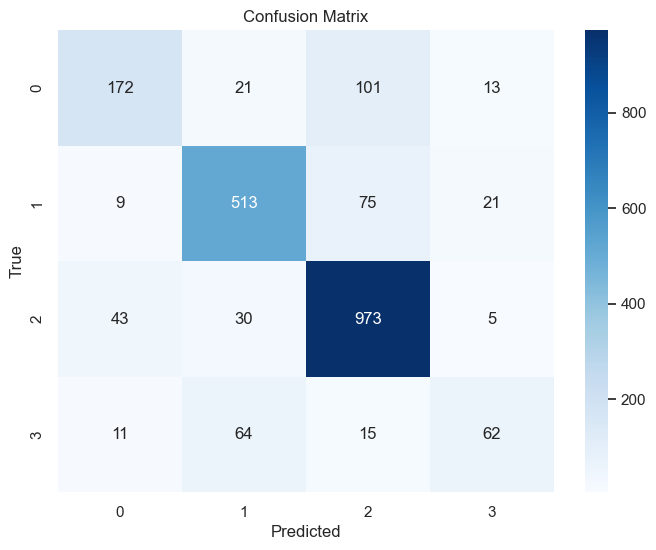

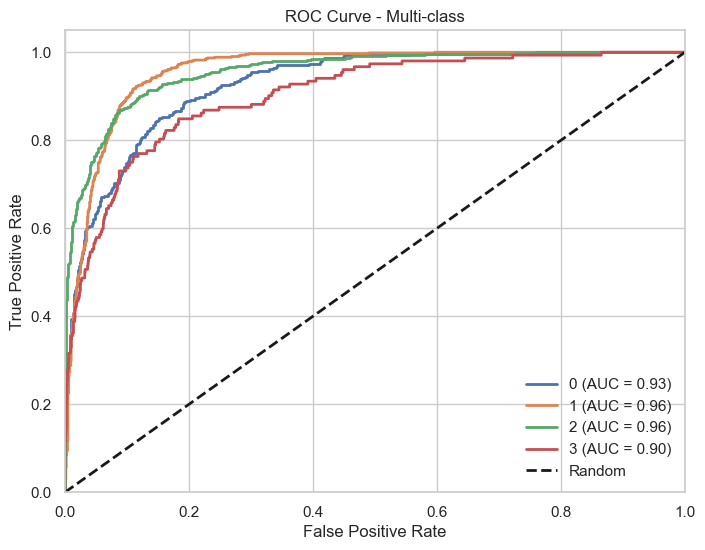

In [225]:
resnet_semi_model.load_best_model('resnet_semi_filtered.keras')
lr_test_result = evaluate_multiclass_classifier(
    resnet_semi_model,
    x_cell_type_test,
    y_cell_type_test,
    class_names=["0", "1", "2", "3"],
    model_name='LeNET'
)

## Final evaluation